# Paper figures

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch 
from tqdm import tqdm
import os
import seaborn as sns

from scipy.stats import pearsonr
# Configur retina display matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
FONT_SIZE = 16
plt.rcParams.update({'font.size': FONT_SIZE})
fig_size = (8,6)

## Helper functions

In [2]:
def get_reults(base_pred_dir, experiment_dir, model_res_dir):
    results = pd.DataFrame()
    for file in tqdm(os.listdir(model_res_dir)):
        if file.endswith(".csv"):
            # Load the predictions
            experiment_csv = pd.read_csv(base_pred_dir + experiment_dir + file, index_col=False)
            experiment_csv = experiment_csv[~experiment_csv['name'].str.contains('ins|del')].reset_index(drop=True)
            inference_csv = pd.read_csv(model_res_dir + file, index_col=False).drop(['mut_type'], axis=1)
            aggregated_df = pd.concat([experiment_csv, inference_csv], axis=1)
            aggregated_df['inferred_dG'] = aggregated_df['unfolded_energies'] - aggregated_df['folded_energies']

            wt = aggregated_df[aggregated_df['mut_type'] == 'wt'].iloc[0]
            aggregated_df['inferred_ddG'] = aggregated_df['inferred_dG'] - wt['inferred_dG'] 
            aggregated_df['ddG'] = aggregated_df['deltaG'] - wt['deltaG']

            # mutation_df = aggregated_df['mut_type'].str.split(':', expand=True).apply(lambda x: pd.Series(list(x)))
            # aggregated_df[[f'mutation_{i}' for i in range(mutation_df.shape[1])]] = mutation_df
            # aggregated_df = aggregated_df[aggregated_df['mutation_1'].isna()] if 'mutation_1' in aggregated_df.columns else aggregated_df
            aggregated_df = aggregated_df[~aggregated_df['mut_type'].str.contains(':')]
            
            # normelize unfolded_energies and folded_energies row with mean 0 and std 1
            aggregated_df['norm_folded_energies'] = (aggregated_df['folded_energies'] - aggregated_df['folded_energies'].mean()) / aggregated_df['folded_energies'].std()
            aggregated_df['norm_unfolded_energies'] = (aggregated_df['unfolded_energies'] - aggregated_df['unfolded_energies'].mean()) / aggregated_df['unfolded_energies'].std()
            # get norm foldeded_energies and norm_unfolded_energies diffrence
            aggregated_df['norm_avg'] = (aggregated_df['norm_unfolded_energies'] + aggregated_df['norm_folded_energies'])/2
            aggregated_df['protein_name'] = file.split('.')[0]
            
            results = pd.concat([results, aggregated_df], axis=0)
    results = results.reset_index(drop=True)
    return results

def print_TM_stat(results):
    """Print the correlation between the predicted and experimental ddG for the ThermoMPNN dataset"""
    TM_path = "../data/ThermoMPNN/mega_test.csv"
    TM_df = pd.read_csv(TM_path)
    TM_df['protein_name'] = TM_df['name'].apply(lambda x: x.split(".")[0])
    TM_results = results[results['name'].isin(TM_df['name_original'])]
    print('TM_results: ', len(TM_results))
    # pc, sp and RMSE
    print(f"pearson coorelation DDG {TM_results[['inferred_ddG', 'ddG']].corr(method='pearson').iloc[0,1]}")
    print(f"spearman coorelation DDG {TM_results[['inferred_ddG', 'ddG']].corr(method='spearman').iloc[0,1]}")
    print(f"RMSE DDG {np.sqrt(np.mean((TM_results['inferred_ddG'] - TM_results['ddG'])**2))}")
    # dg correlation
    print(f"pearson coorelation DG {TM_results[['inferred_dG', 'deltaG']].corr(method='pearson').iloc[0,1]}")
    print(f"spearman coorelation DG {TM_results[['inferred_dG', 'deltaG']].corr(method='spearman').iloc[0,1]}")
    print(f"RMSE DG {np.sqrt(np.mean((TM_results['inferred_dG'] - TM_results['deltaG'])**2))}")
    
    # per protein correlation
    print('Per protein correlation')
    corr_per_protein = results.groupby('protein_name').apply(lambda x: x[['inferred_dG', 'deltaG']].corr().iloc[0,1])
    print("Mean per protein correlation: ", corr_per_protein.mean())

def plot_TM_stat(results):
    """plot the correlation between the predicted and experimental ddG for the ThermoMPNN dataset"""
    TM_path = "../data/ThermoMPNN/mega_test.csv"
    TM_df = pd.read_csv(TM_path)
    TM_df['protein_name'] = TM_df['name'].apply(lambda x: x.split(".")[0])
    TM_results = results[results['name'].isin(TM_df['name_original'])]
    corr_per_protein = results.groupby('protein_name').apply(lambda x: x[['inferred_dG', 'deltaG']].corr().iloc[0,1])
    plt.figure(figsize=fig_size)
    sns.histplot(corr_per_protein, bins=20, kde=True)
    plt.xlabel('Correlation', fontsize=FONT_SIZE)
    plt.ylabel('Frequency', fontsize=FONT_SIZE)
    plt.title('Per protein correlation', fontsize=FONT_SIZE)
    plt.xticks(fontsize=FONT_SIZE - 2)
    plt.yticks(fontsize=FONT_SIZE - 2)
    plt.grid(True)
    plt.show()

def plot_results(results, model_type, title=' Predicted vs Experimental ddG'):
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=results['inferred_dG'], y=results['ddG'])    

    plt.xlabel('Predicted ddG')
    plt.ylabel('Experimental ddG')
    plt.title(model_type + title)
    plt.show()
    
    # get correlation for each protein
def get_corr_per_protein(results):
    corr_per_protein = results.groupby('protein_name').apply(lambda x: x[['inferred_dG', 'deltaG']].corr().iloc[0,1])
    return corr_per_protein

In [3]:
base_pred_dir = '../data/Processed_K50_dG_datasets/'
experiment_dir = 'mutation_datasets/' 

In [4]:
# model_res_dir = base_pred_dir+'mutation_outputs/'+'trianed_models-2cycle_drop/12_final_model.pt/'
# model_res_dir = base_pred_dir+'mutation_outputs/'+"trianed_models-cycle2_5/24_final_model.pt/"
model_res_dir = base_pred_dir+'mutation_outputs/'+"trianed_models-light_attention/22_final_model.pt/"
results = get_reults(base_pred_dir, experiment_dir, model_res_dir)
results.head()

  0%|          | 0/368 [00:00<?, ?it/s]

100%|██████████| 368/368 [00:47<00:00,  7.68it/s]


,name,deltaG,aa_seq,mut_type,ddG_ML,Stabilizing_mut,folded_energies,unfolded_energies,inferred_dG,inferred_ddG,ddG,norm_folded_energies,norm_unfolded_energies,norm_avg,protein_name
0,1A0N.pdb_L7S,2.560197,VTLFVASYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGE...,wt,-0.007128562765898572,False,-39.950645,-0.120943,39.829702,0.000000e+00,0.000000,0.220299,-0.328602,-0.054151,1A0N
1,1A0N.pdb_L7S_wty,2.582720,VTLFVASYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGE...,wt,0.015393821934913454,False,-39.950645,-0.120943,39.829702,-3.400000e-07,0.022522,0.220299,-0.328608,-0.054154,1A0N
2,1A0N.pdb_L7S_wtm,2.567326,VTLFVASYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGE...,wt,0.0,False,-39.950645,-0.120943,39.829702,2.000000e-08,0.007129,0.220299,-0.328601,-0.054151,1A0N
3,1A0N.pdb_L7S_wte,2.552018,VTLFVASYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGE...,wt,-0.015307414252838214,False,-39.950645,-0.120943,39.829702,-1.300000e-07,-0.008179,0.220299,-0.328604,-0.054153,1A0N
4,1A0N.pdb_L7S_wth,2.595072,VTLFVASYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGE...,wt,0.02774569070809063,False,-39.950645,-0.120942,39.829703,2.900000e-07,0.034874,0.220299,-0.328597,-0.054149,1A0N


# Person correlation histogram and p-value

In [7]:
# print delta delta G correlation
print(f"DDG pearson correlation : {pearsonr(results['inferred_ddG'], results['ddG'])[0]}")
print(f"DDG spearman correlation : {results[['inferred_ddG', 'ddG']].corr(method='spearman').iloc[0,1]}")
print(f"DDG RMSE : {np.sqrt(np.mean((results['inferred_ddG'] - results['ddG'])**2))}")
# DG
print(f"DG pearson correlation : {pearsonr(results['inferred_dG'], results['deltaG'])[0]}")
print(f"DG spearman correlation : {results[['inferred_dG', 'deltaG']].corr(method='spearman').iloc[0,1]}")
print(f"DG RMSE : {np.sqrt(np.mean((results['inferred_dG'] - results['deltaG'])**2))}")

DDG pearson correlation : 0.11746027360145234
DDG spearman correlation : 0.15932530540877254
DDG RMSE : 2.7462625645390704
DG pearson correlation : 0.20827376414666726
DG spearman correlation : 0.22946790262996586
DG RMSE : 33.84093962650947


In [8]:
# Get pearson correlation and protein wise correlation
corr_df = pd.DataFrame()
gr_results = results.groupby('protein_name')
corr_df['protein_name'] = gr_results.apply(lambda x: x['protein_name'].iloc[0]).values
corr_df['pearson_corr'] = gr_results.apply(lambda x: x[['inferred_dG', 'deltaG']].corr(method='pearson').iloc[0,1]).values
corr_df['folded_pearson_corr'] = gr_results.apply(lambda x: x[['folded_energies', 'deltaG']].corr().iloc[0,1]).values
corr_df['p_values'] = gr_results.apply(lambda x: pearsonr(x['inferred_dG'], x['deltaG'])[1]).values
corr_df['std_deltaG'] = gr_results.apply(lambda x: x['deltaG'].std()).values
corr_df.head()

,protein_name,pearson_corr,folded_pearson_corr,p_values,std_deltaG
0,1A0N,0.187790,-0.233174,5.463747e-19,1.137473
1,1A32,0.306416,-0.313519,1.516663e-27,0.656785
2,1AOY,-0.044227,0.074664,1.087905e-01,1.145764
3,1B7J,0.412744,-0.425188,2.020199e-51,2.893174
4,1BK2,-0.070207,-0.032697,6.932793e-05,2.207418


In [9]:
# Sort by pearson correlation
corr_df = corr_df.sort_values('pearson_corr', ascending=False)
corr_df

,protein_name,pearson_corr,folded_pearson_corr,p_values,std_deltaG
240,6YSE,0.550135,-0.552065,9.743097e-55,1.523749
174,2PTL,0.547007,-0.539482,3.402415e-276,1.968836
77,2EXD,0.529925,-0.546637,3.611136e-81,0.848133
107,2KWH,0.527659,-0.537088,3.991435e-72,0.847523
217,5UYO,0.519593,-0.549814,4.731510e-54,0.931980
...,...,...,...,...,...
23,1IGV,-0.162757,0.178182,7.781472e-10,0.890261
348,r15_550_TrROS_Hall,-0.169125,0.189145,8.763834e-09,0.680014
355,r6_831_TrROS_Hall,-0.169860,0.164998,2.405672e-08,0.953501
177,2ROT,-0.182891,0.150088,5.032611e-31,1.704601


In [10]:
# mean and median
print('Mean pearson corr: ', corr_df['pearson_corr'].mean())
print('Median pearson corr: ', corr_df['pearson_corr'].median())
print('All protein correlation: ', pearsonr(results['inferred_dG'], results['deltaG']))

Mean pearson corr:  0.2281973100723502
Median pearson corr:  0.24849379942884325
All protein correlation:  (0.20827376414666726, 0.0)


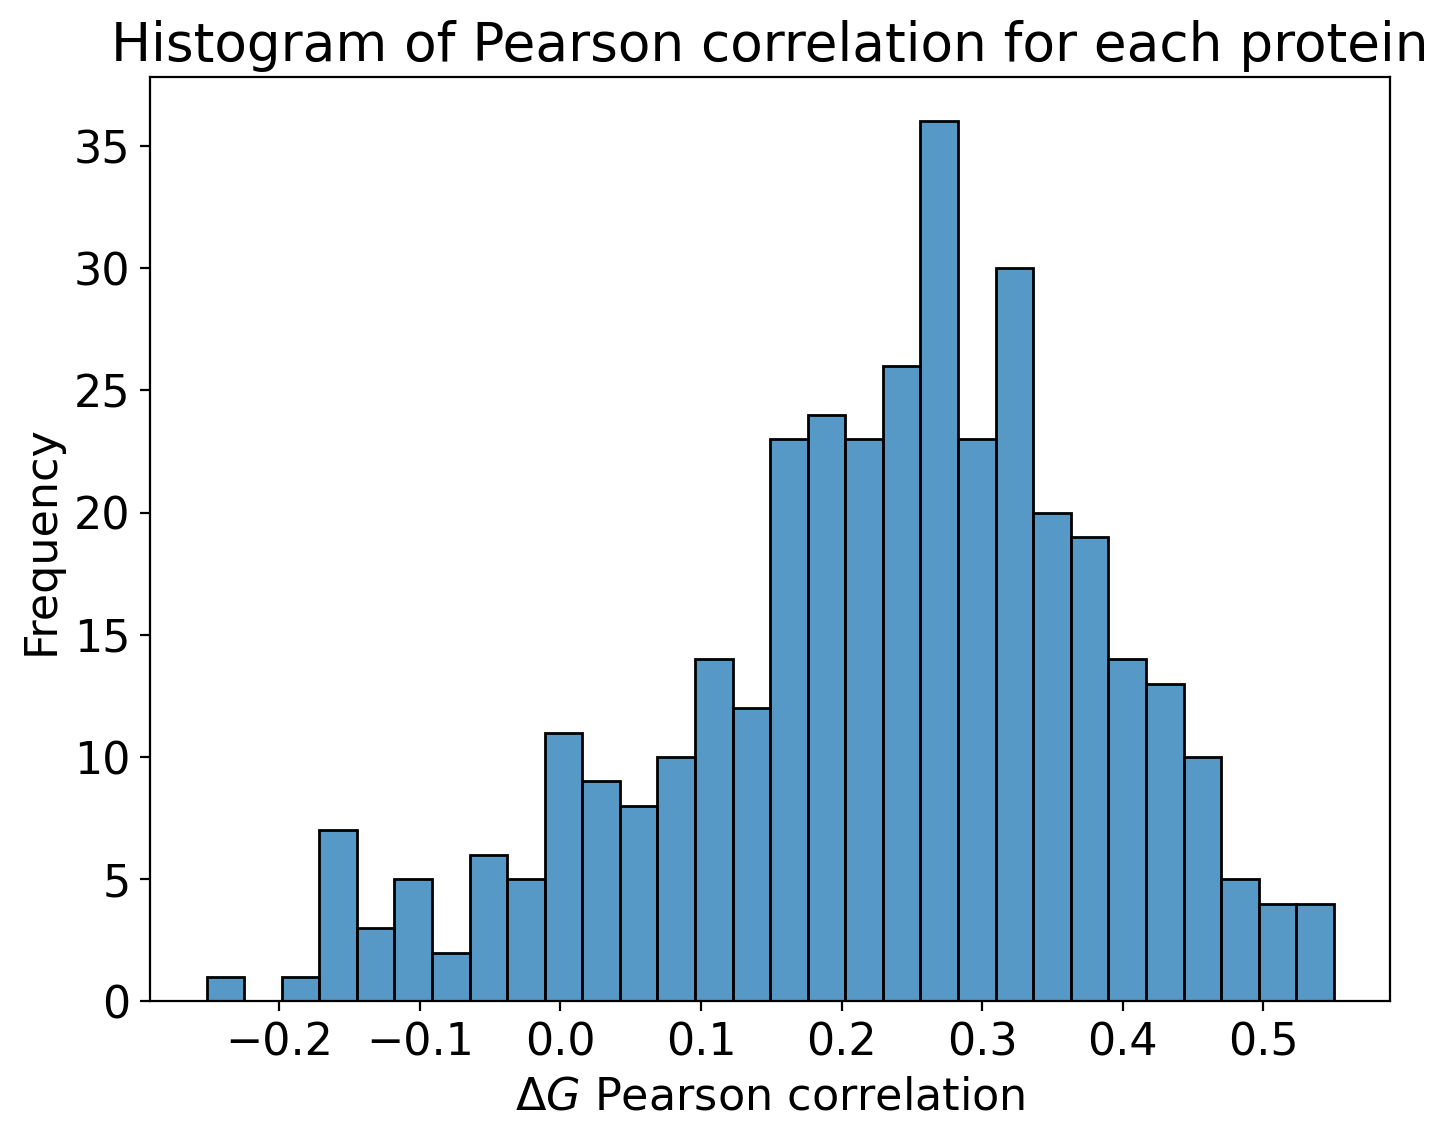

In [11]:
# plot histogram of pearson correlation
plt.figure(figsize=fig_size)
sns.histplot(corr_df['pearson_corr'], bins=30)
plt.xlabel('$\Delta G$ Pearson correlation')  
plt.ylabel('Frequency')
plt.title('Histogram of Pearson correlation for each protein')
plt.show()

In [12]:
corr_df['pearson_corr'].describe()

count    368.000000
mean       0.228197
std        0.155307
min       -0.251771
25%        0.147799
50%        0.248494
75%        0.331022
max        0.550135
Name: pearson_corr, dtype: float64

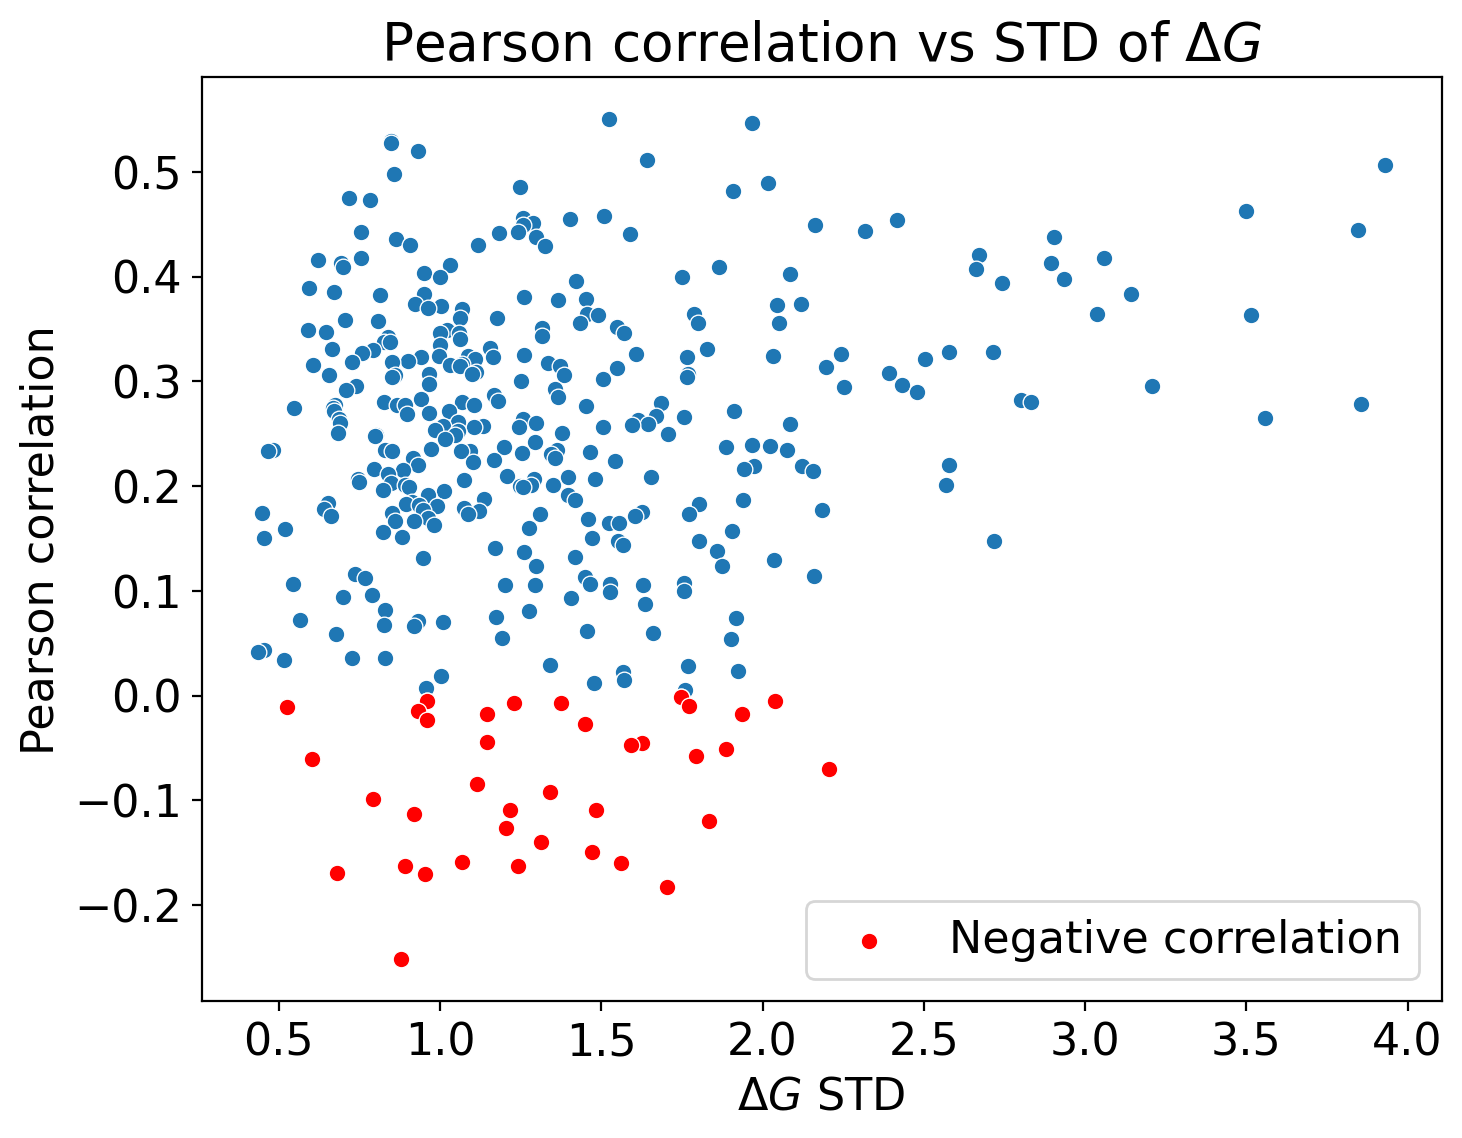

correlation:0.14944612206336322


In [13]:
# Pearson correlation vs STD of DG
plt.figure(figsize=fig_size)
sns.scatterplot(x=corr_df['std_deltaG'], y=corr_df['pearson_corr'])
sns.scatterplot(x=corr_df[corr_df['pearson_corr']<0]['std_deltaG'], y=corr_df[corr_df['pearson_corr']<0]['pearson_corr'], color='red', label='Negative correlation')
plt.xlabel('$\Delta G$ STD')
plt.ylabel('Pearson correlation')
plt.title('Pearson correlation vs STD of $\Delta G$')
plt.show()
print(f"correlation:{corr_df['std_deltaG'].corr(corr_df['pearson_corr'])}")

In [11]:
corr_df[corr_df['pearson_corr']<0]['std_deltaG'].max()

2.1220163777228644

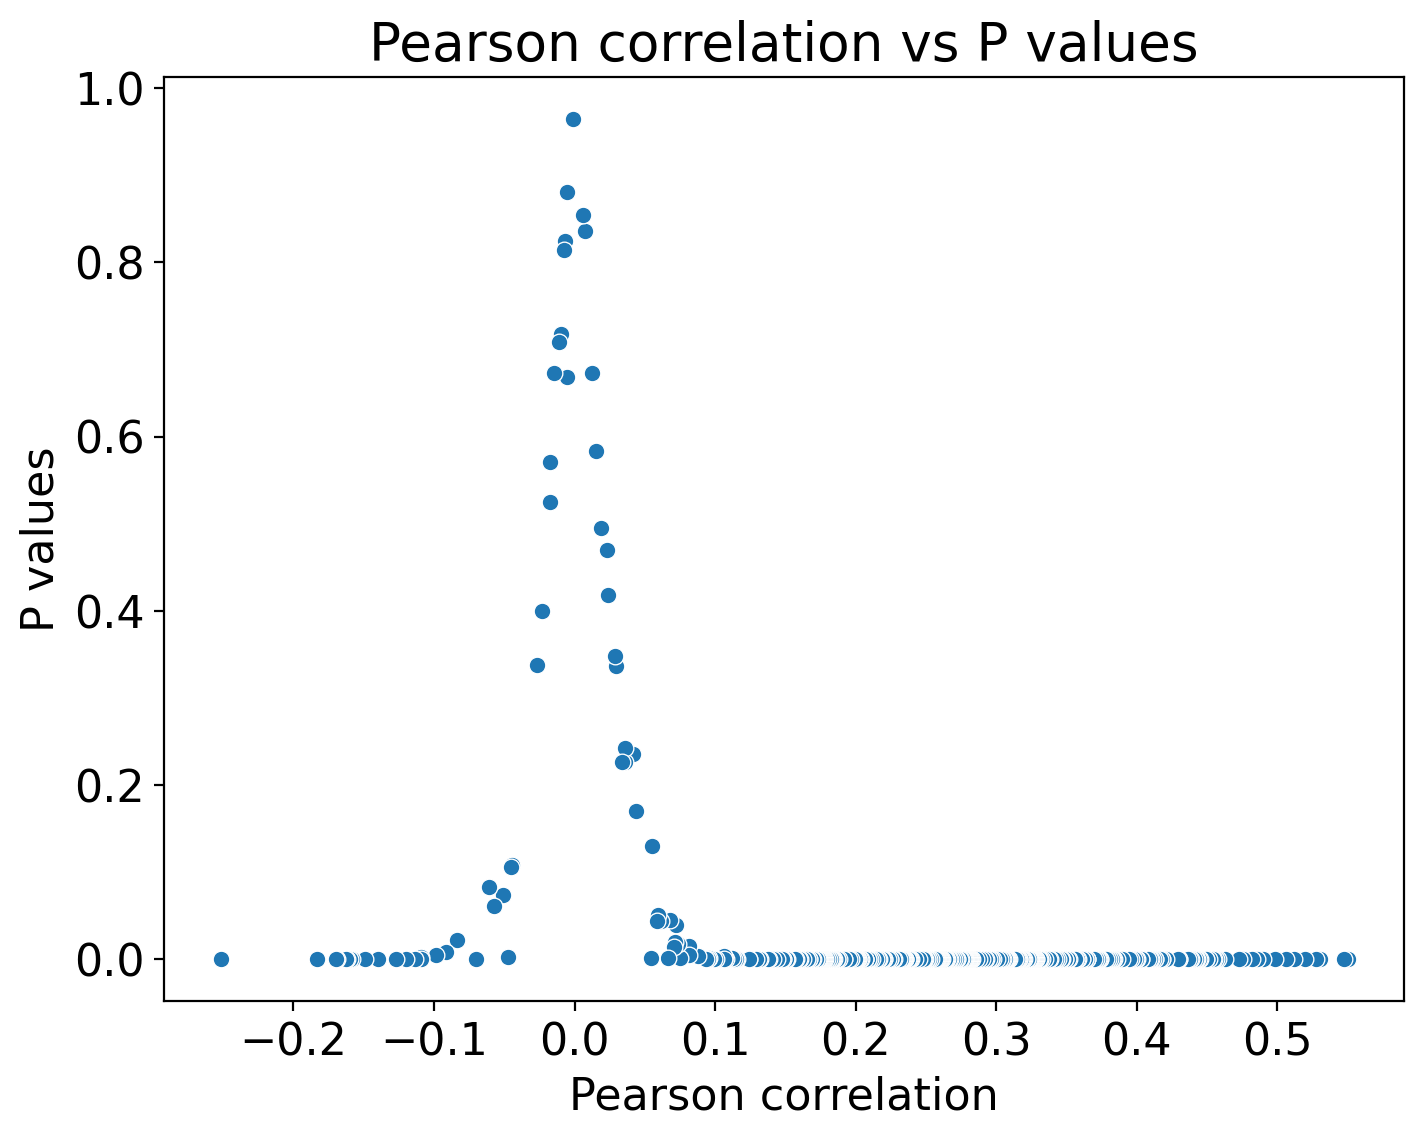

P value :0.0, Pearson correlation: 0.20827376414666726


In [14]:
# p values vs pearson correlation
plt.figure(figsize=fig_size)
sns.scatterplot(x=corr_df['pearson_corr'], y=corr_df['p_values'])
plt.xlabel('Pearson correlation')
plt.ylabel('P values')
plt.title('Pearson correlation vs P values')
plt.show()
print(f"P value :{pearsonr(results['inferred_dG'], results['deltaG'])[1]}, Pearson correlation: {pearsonr(results['inferred_dG'], results['deltaG'])[0]}")

In [15]:
pearsonr(results['inferred_dG'], results['deltaG'])

(0.20827376414666726, 0.0)

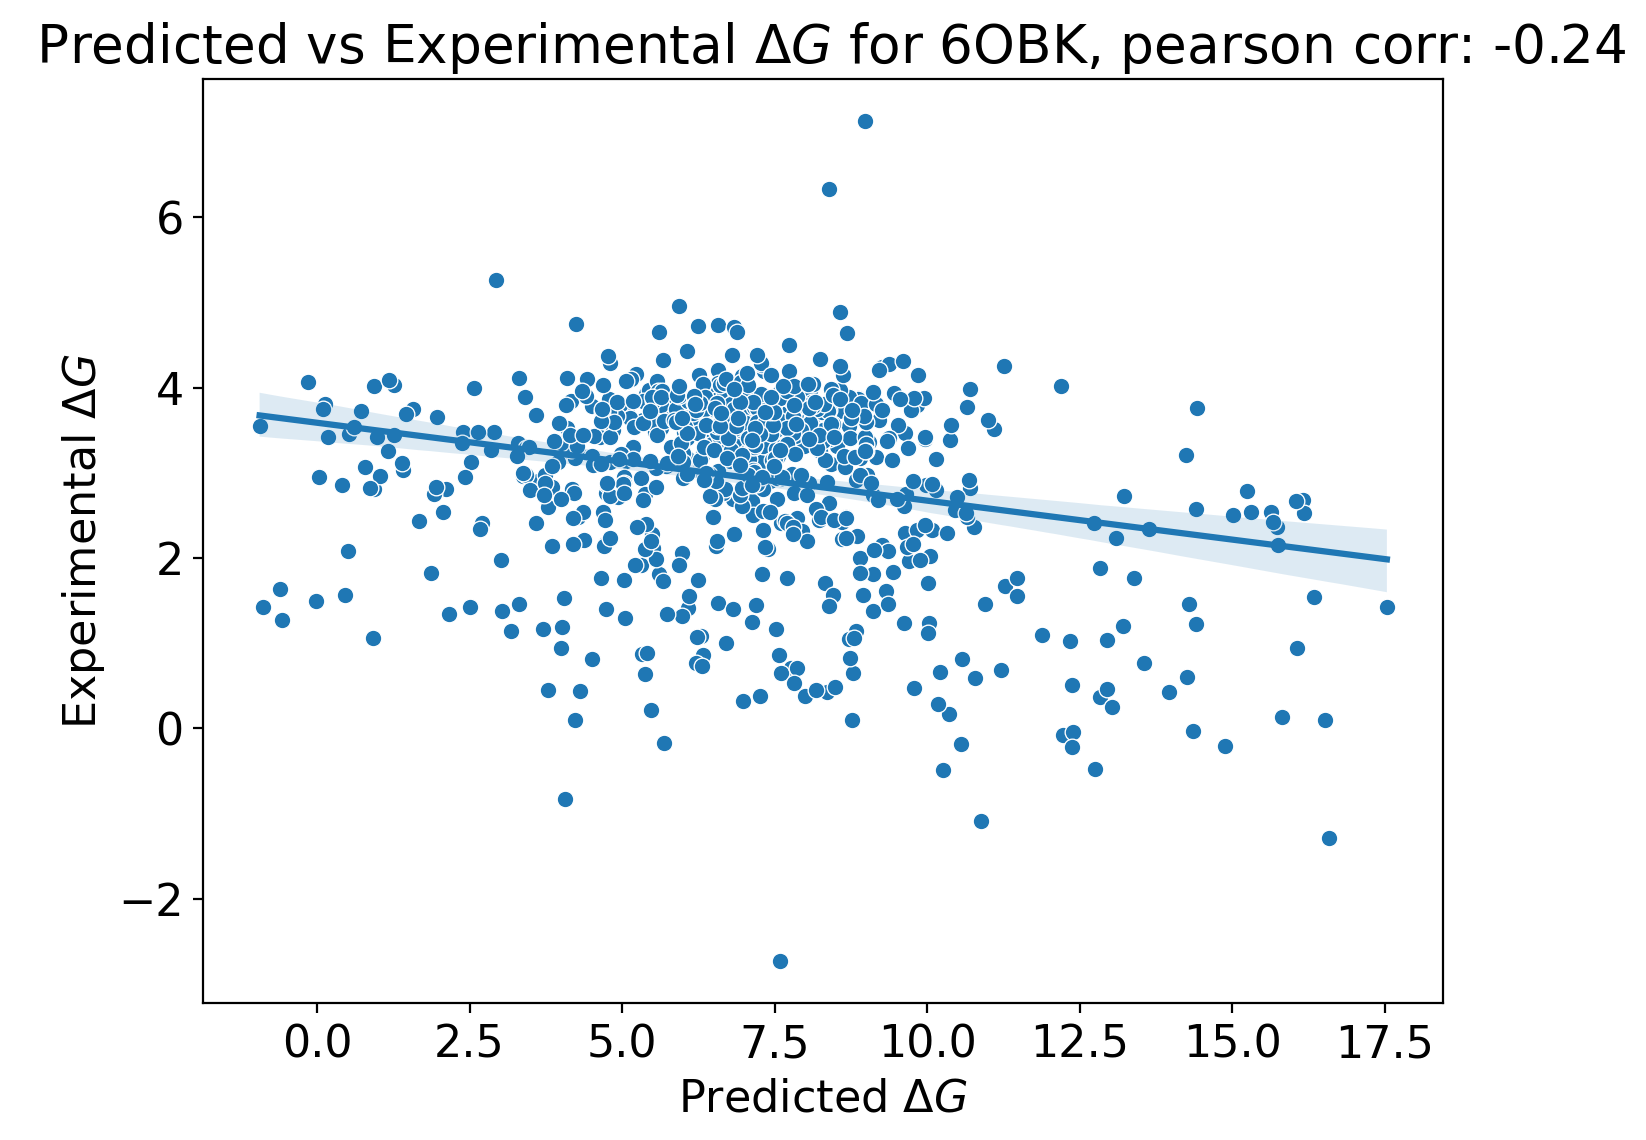

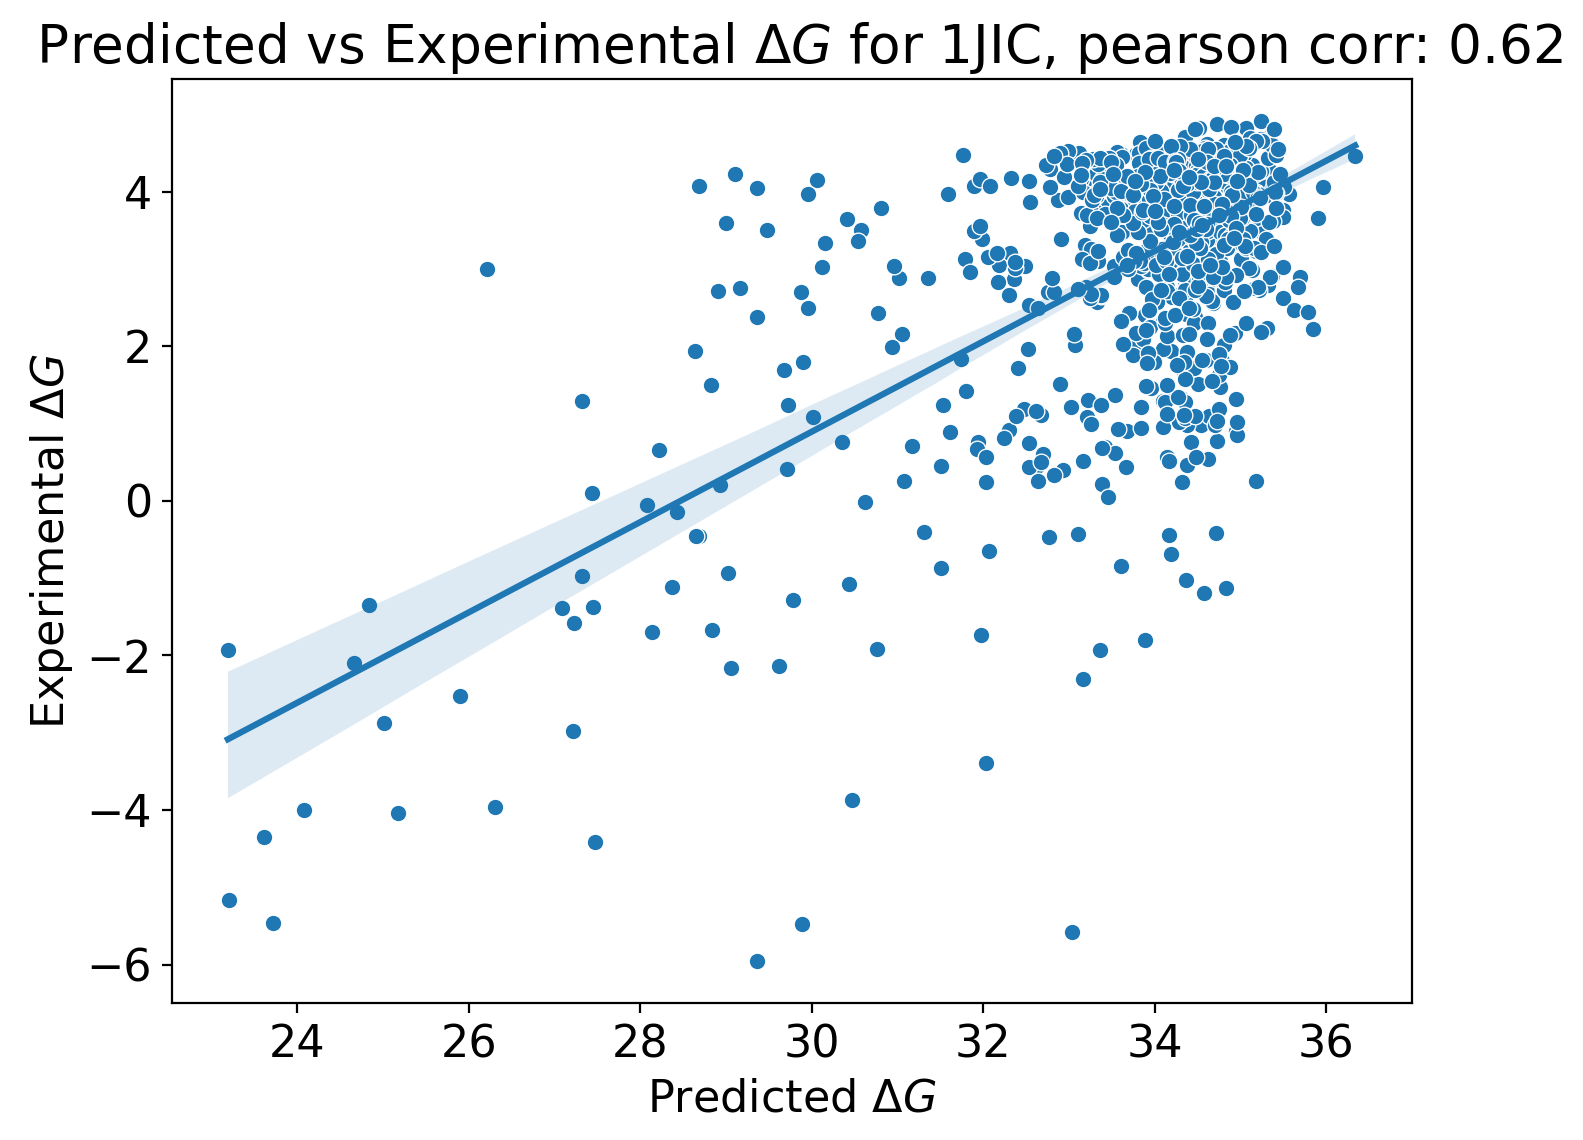

In [14]:
# Plot scatter plot for the worst protein and best protein
worst_protein = corr_df[corr_df['pearson_corr'] == corr_df['pearson_corr'].min()]['protein_name'].values[0]
best_protein = corr_df[corr_df['pearson_corr'] == corr_df['pearson_corr'].max()]['protein_name'].values[0]

worst_protein_df = results[results['protein_name'] == worst_protein]
best_protein_df = results[results['protein_name'] == best_protein]

plt.figure(figsize=fig_size)
sns.scatterplot(x=worst_protein_df['inferred_dG'], y=worst_protein_df['deltaG'])
sns.regplot(x=worst_protein_df['inferred_dG'], y=worst_protein_df['deltaG'], scatter=False)
plt.xlabel('Predicted $\Delta G$')
plt.ylabel('Experimental $\Delta G$')
plt.title(f' Predicted vs Experimental $\Delta G$ for {worst_protein}, pearson corr: {round(corr_df[corr_df["protein_name"] == worst_protein]["pearson_corr"].values[0], 2)}')
plt.show()

plt.figure(figsize=fig_size)
sns.scatterplot(x=best_protein_df['inferred_dG'], y=best_protein_df['deltaG'])
sns.regplot(x=best_protein_df['inferred_dG'], y=best_protein_df['deltaG'], scatter=False)
plt.xlabel('Predicted $\Delta G$')
plt.ylabel('Experimental $\Delta G$')
plt.title(f' Predicted vs Experimental $\Delta G$ for {best_protein}, pearson corr: {round(corr_df[corr_df["protein_name"] == best_protein]["pearson_corr"].values[0], 2)}')
plt.show()

In [15]:
corr_df['pearson_corr'].describe()

count    368.000000
mean       0.229821
std        0.154133
min       -0.238960
25%        0.134780
50%        0.241800
75%        0.342840
max        0.623550
Name: pearson_corr, dtype: float64

In [16]:
results[results['protein_name'] == '6OBK'][['deltaG','inferred_dG']].corr()

,deltaG,inferred_dG
deltaG,1.00000,-0.23896
inferred_dG,-0.23896,1.00000


In [17]:
corr_df[corr_df['pearson_corr'].min() == corr_df['pearson_corr']]

,protein_name,pearson_corr,folded_pearson_corr,p_values,std_deltaG
235,6OBK,-0.23896,0.174497,4.686069e-11,1.116256


In [18]:
corr_df[corr_df['pearson_corr'].max() == corr_df['pearson_corr']]

,protein_name,pearson_corr,folded_pearson_corr,p_values,std_deltaG
24,1JIC,0.62355,-0.426245,3.555231e-114,1.596681


In [19]:
type(corr_df['pearson_corr'][0])

numpy.float64

In [20]:
# list of protein and correlation sorted by correlation
gr_df = results.groupby('protein_name').apply(lambda x: x[['inferred_dG', 'deltaG']].corr().iloc[0,1]).reset_index()
display(gr_df.sort_values(by=0, ascending=False))

,protein_name,0
24,1JIC,0.623550
284,EHEE_rd2_0601,0.587534
178,2RRT,0.584980
367,v2_6IVS,0.556363
33,1PGX,0.535832
...,...,...
176,2RJV,-0.143851
311,HEEH_KT_rd6_3546,-0.147986
177,2ROT,-0.193305
17,1H8K,-0.225557


In [21]:
import pandas as pd

a = pd.read_csv('../data/Processed_K50_dG_datasets/mutation_datasets/6OBK.csv')

In [22]:
a.head()

,name,deltaG,aa_seq,mut_type,ddG_ML,Stabilizing_mut
0,6OBK.pdb,4.201744,NKEHILAQKEVLTPIEYEHYVKHLFDIGEITKELYIELSS,wt,0.1465610437110625,-
1,6OBK.pdb_wtm,4.055183,NKEHILAQKEVLTPIEYEHYVKHLFDIGEITKELYIELSS,wt,0.0,False
2,6OBK.pdb_wty,3.962383,NKEHILAQKEVLTPIEYEHYVKHLFDIGEITKELYIELSS,wt,-0.09279996646764843,False
3,6OBK.pdb_wte,3.867430,NKEHILAQKEVLTPIEYEHYVKHLFDIGEITKELYIELSS,wt,-0.1877530046743976,False
4,6OBK.pdb_wth,4.734065,NKEHILAQKEVLTPIEYEHYVKHLFDIGEITKELYIELSS,wt,-,-


In [23]:
a['mut_type'].str.split(':', expand=True) 

,0
0,wt
1,wt
2,wt
3,wt
4,wt
...,...
854,S40F
855,S40P
856,insG40
857,insA40


# Foldx values

In [16]:
import os
import re
from tqdm import tqdm   
from scipy.stats import pearsonr

def extract_energy_values(file_content, protein_name):
    # Split the content by lines
    lines = file_content.split('\n')
    # sort lines
    df = pd.DataFrame()
    df['line'] = lines
    df['variant'] = df['line'].apply(lambda x: x.split('\t')[0])
    # remove lines without protein name
    df.drop(df[~df['variant'].str.contains(protein_name)].index, inplace=True)
    df['variant_number'] = df['variant'].apply(lambda x: int(x.split('_')[-1]))
    df = df.sort_values('variant_number')
    # drop duplicats
    df.drop_duplicates(subset=['variant'], inplace=True)
    df['energy'] = df['line'].apply(lambda x: x.split('\t')[2])
    
    return df['energy'].to_list()

In [17]:
foldx_ds_path = "../data/Processed_K50_dG_datasets/foldx"
protein  = '1A32'
foldx_enerrgy_path = f'{foldx_ds_path}/{protein}/foldx_output2/Average_{protein}.fxout'
with open(foldx_enerrgy_path, 'r') as f:
    file_content = f.read()
len(extract_energy_values(file_content,protein))

1197

In [18]:
foldx_ds_path = "../data/Processed_K50_dG_datasets/foldx"
pdb_path = "../data/Processed_K50_dG_datasets/AlphaFold_model_PDBs"
foldx_ds = os.listdir(foldx_ds_path)

summery_df = pd.DataFrame()

for protein in tqdm(foldx_ds):
    foldx_enerrgy_path = f'{foldx_ds_path}/{protein}/foldx_output2/Average_{protein}.fxout'
    # check if the file exists
    if not os.path.exists(foldx_enerrgy_path):
        continue
    with open(foldx_enerrgy_path, 'r') as f:
        file_content = f.read()
    df = pd.read_csv(f'{foldx_ds_path}/{protein}/foldx.csv')
    # Add FoldX energy values to the dataframe

    df['foldx_dg'] = extract_energy_values(file_content, protein)
    df.to_csv(f'{foldx_ds_path}/{protein}/foldx.csv', index=False)
    summery_df = pd.concat([summery_df, df])

100%|██████████| 868/868 [00:53<00:00, 16.19it/s]


In [19]:
summery_df

,name,pdb_path,mut_type,deltaG,foldx_dg
0,1A32.pdb_S1Q,./data/Processed_K50_dG_datasets/AlphaFold_mod...,S1Q,2.343605,-0.58518
1,1A32.pdb_S1E,./data/Processed_K50_dG_datasets/AlphaFold_mod...,S1E,2.469428,-0.239322
2,1A32.pdb_S1N,./data/Processed_K50_dG_datasets/AlphaFold_mod...,S1N,2.613610,-0.537254
3,1A32.pdb_S1H,./data/Processed_K50_dG_datasets/AlphaFold_mod...,S1H,2.524459,0.119191
4,1A32.pdb_S1D,./data/Processed_K50_dG_datasets/AlphaFold_mod...,S1D,2.733224,0.192063
...,...,...,...,...,...
906,v2_6IVS.pdb_V48K,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V48K,3.795679,-0.0615497
907,v2_6IVS.pdb_V48R,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V48R,3.492887,-0.391701
908,v2_6IVS.pdb_V48F,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V48F,3.612490,-0.215249
909,v2_6IVS.pdb_V48W,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V48W,3.544382,-0.727039


In [20]:
foldx_res = summery_df
foldx_res['protein_name'] = foldx_res['name'].apply(lambda x: x.split('.')[0])
foldx_res['pred_deltaG'] = summery_df['foldx_dg'].apply(lambda x: float(x))
# remove ins and del
foldx_res = foldx_res[~foldx_res['mut_type'].str.contains('ins|del')].reset_index(drop=True)
foldx_res

,name,pdb_path,mut_type,deltaG,foldx_dg,protein_name,pred_deltaG
0,1A32.pdb_S1Q,./data/Processed_K50_dG_datasets/AlphaFold_mod...,S1Q,2.343605,-0.58518,1A32,-0.585180
1,1A32.pdb_S1E,./data/Processed_K50_dG_datasets/AlphaFold_mod...,S1E,2.469428,-0.239322,1A32,-0.239322
2,1A32.pdb_S1N,./data/Processed_K50_dG_datasets/AlphaFold_mod...,S1N,2.613610,-0.537254,1A32,-0.537254
3,1A32.pdb_S1H,./data/Processed_K50_dG_datasets/AlphaFold_mod...,S1H,2.524459,0.119191,1A32,0.119191
4,1A32.pdb_S1D,./data/Processed_K50_dG_datasets/AlphaFold_mod...,S1D,2.733224,0.192063,1A32,0.192063
...,...,...,...,...,...,...,...
525076,v2_6IVS.pdb_V48K,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V48K,3.795679,-0.0615497,v2_6IVS,-0.061550
525077,v2_6IVS.pdb_V48R,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V48R,3.492887,-0.391701,v2_6IVS,-0.391701
525078,v2_6IVS.pdb_V48F,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V48F,3.612490,-0.215249,v2_6IVS,-0.215249
525079,v2_6IVS.pdb_V48W,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V48W,3.544382,-0.727039,v2_6IVS,-0.727039


In [21]:
foldx_res.describe()

,deltaG,pred_deltaG
count,525081.000000,525081.000000
mean,1.563978,2.245218
std,2.063605,3.304681
min,-15.275287,-5.710930
25%,0.474646,0.226258
50%,1.572031,1.305870
75%,2.760548,3.309100
max,16.579383,78.806700


In [ ]:
print(f"pearson coorelation DDG {foldx_res[['pred_deltaG', 'deltaG']].corr(method='pearson').iloc[0,1]}")
print(f"spearman coorelation DDG {foldx_res[['pred_deltaG', 'deltaG']].corr(method='spearman').iloc[0,1]}")
print(f"RMSE DDG {np.sqrt(np.mean((foldx_res['pred_deltaG'] - foldx_res['deltaG'])**2))}")

In [22]:
# pearson correlation between the predicted and experimental ddG for the ThermoMPNN dataset
foldx_corr = pd.DataFrame()
gr_foldx_res = foldx_res.groupby('protein_name')
foldx_corr['protein_name'] = gr_foldx_res.apply(lambda x: x['protein_name'].iloc[0]).values
foldx_corr['pearson_corr'] = gr_foldx_res.apply(lambda x: x[['pred_deltaG', 'deltaG']].corr(method='pearson').iloc[0,1]).values
foldx_corr['folded_pearson_corr'] = gr_foldx_res.apply(lambda x: x[['pred_deltaG', 'deltaG']].corr().iloc[0,1]).values
foldx_corr['p_values'] = gr_foldx_res.apply(lambda x: pearsonr(x['pred_deltaG'], x['deltaG'])[1]).values
foldx_corr['std_deltaG'] = gr_foldx_res.apply(lambda x: x['deltaG'].std()).values

In [23]:
len(gr_foldx_res)

330

In [26]:
# Check what proteins are missing
head_df_protein = gr_df['protein_name'].values
foldx_df_protein = foldx_corr['protein_name'].values
missing_proteins = [protein for protein in head_df_protein if protein not in foldx_df_protein]
match_proteins = [protein for protein in head_df_protein if protein in foldx_df_protein]
print('missing_proteins: ', len(missing_proteins))
print('match_proteins: ', len(match_proteins))

missing_proteins:  0
match_proteins:  330


In [27]:
# Save unmacched proteins to a file
pd.DataFrame(missing_proteins,columns=['protein_name']).to_csv('missing_proteins.csv', index=False)

In [28]:
# mean and median
print('Mean pearson corr per protein: ', foldx_corr['pearson_corr'].mean())
print('Median pearson corr per protein: ', foldx_corr['pearson_corr'].median())
# print coorelation for all proteins
print('Pearson correlation all proteins: ', foldx_res['pred_deltaG'].corr(foldx_res['deltaG']))

Mean pearson corr per protein:  -0.5232496712213643
Median pearson corr per protein:  -0.5358404584515268
Pearson correlation all proteins:  -0.41406932968409405


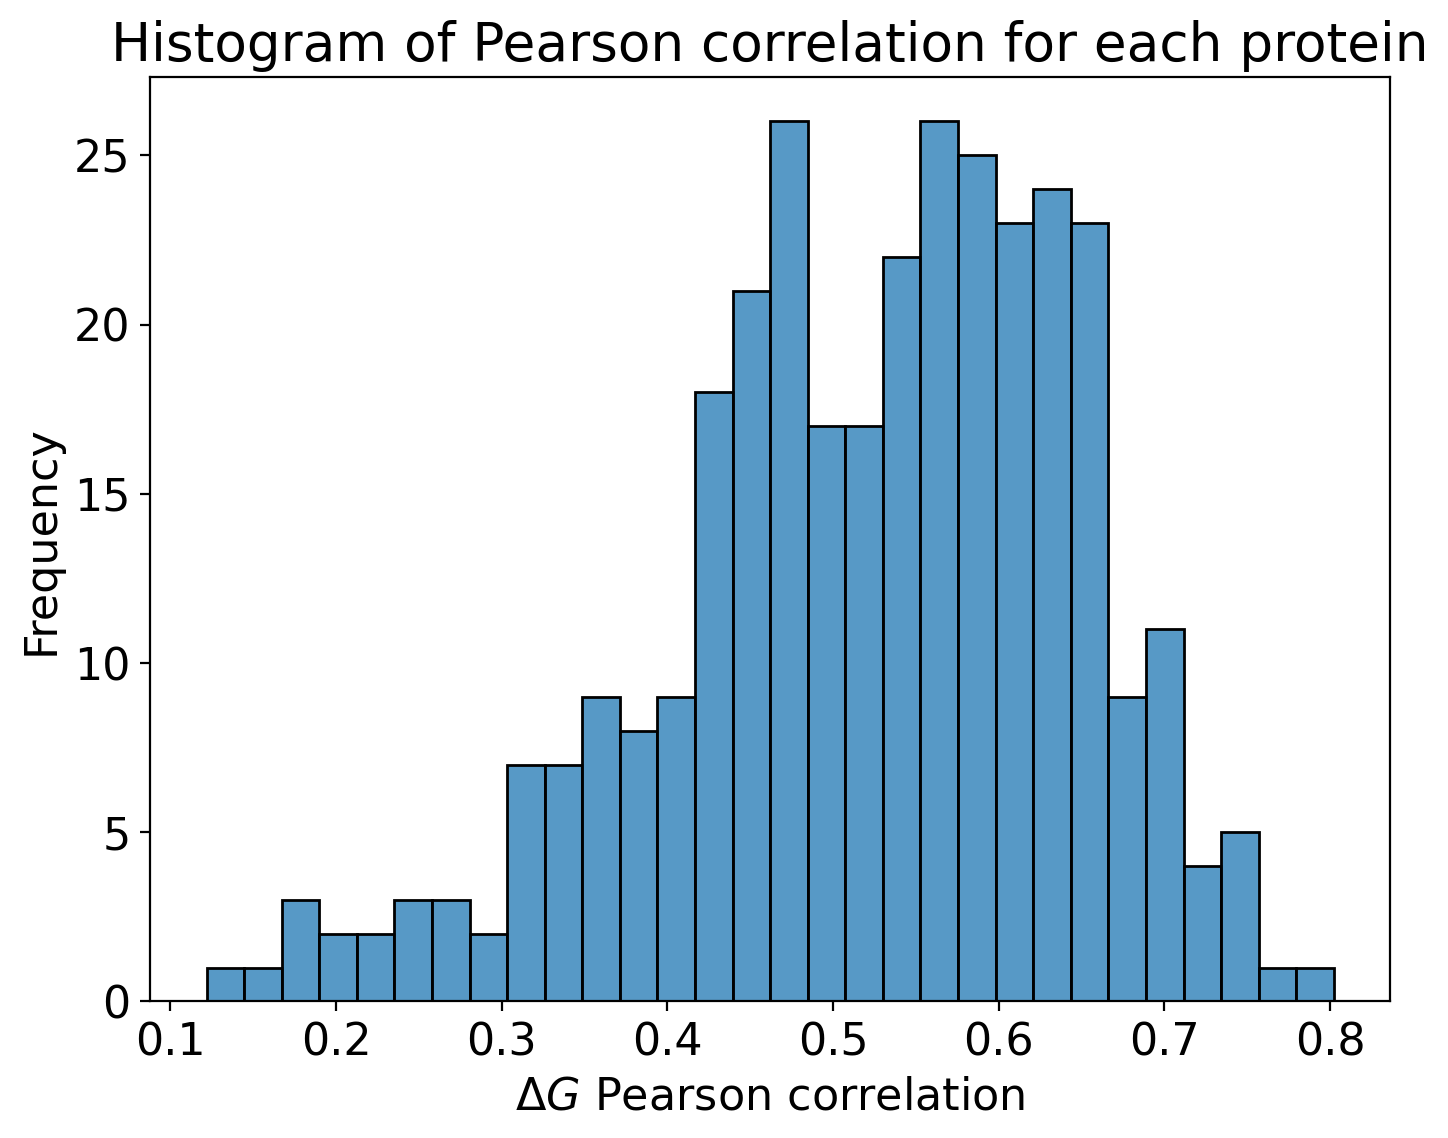

In [33]:
# print histogram of pearson correlation
plt.figure(figsize=fig_size)
sns.histplot(-1*foldx_corr['pearson_corr'], bins=30)
plt.xlabel('$\Delta G$ Pearson correlation')
plt.ylabel('Frequency')
plt.title('Histogram of Pearson correlation for each protein')
plt.show()

In [34]:
# show min and max correlation
foldx_corr = foldx_corr.sort_values('pearson_corr', ascending=False)
foldx_corr


,protein_name,pearson_corr,folded_pearson_corr,p_values,std_deltaG
287,HHH_rd1_0598,-0.121857,-0.121857,5.260965e-04,0.747278
14,1IFY,-0.160931,-0.160931,7.404595e-08,1.246163
182,5VNT,-0.174356,-0.174356,4.796757e-35,0.579949
112,2M0Y,-0.180046,-0.180046,3.928213e-25,1.107317
214,EEHEE_rd3_0657,-0.187186,-0.187186,1.225218e-07,1.320085
...,...,...,...,...,...
138,2N88,-0.745366,-0.745366,3.292310e-302,1.286721
192,6IWS,-0.753056,-0.753056,0.000000e+00,2.121218
111,2M0X,-0.754644,-0.754644,0.000000e+00,2.434855
162,3V1A,-0.763099,-0.763099,1.045390e-159,0.820936


In [35]:
foldx_res[foldx_res['protein_name'] == '6XQC'][['deltaG','pred_deltaG']]

,deltaG,pred_deltaG
380297,5.101474,2.47639
380298,3.865561,3.10424
380299,4.381885,2.60516
380300,6.100348,2.81881
380301,3.791861,2.84697
...,...,...
382059,2.406562,7.87602
382060,1.392198,10.22140
382061,0.260665,11.92750
382062,1.103630,7.59369


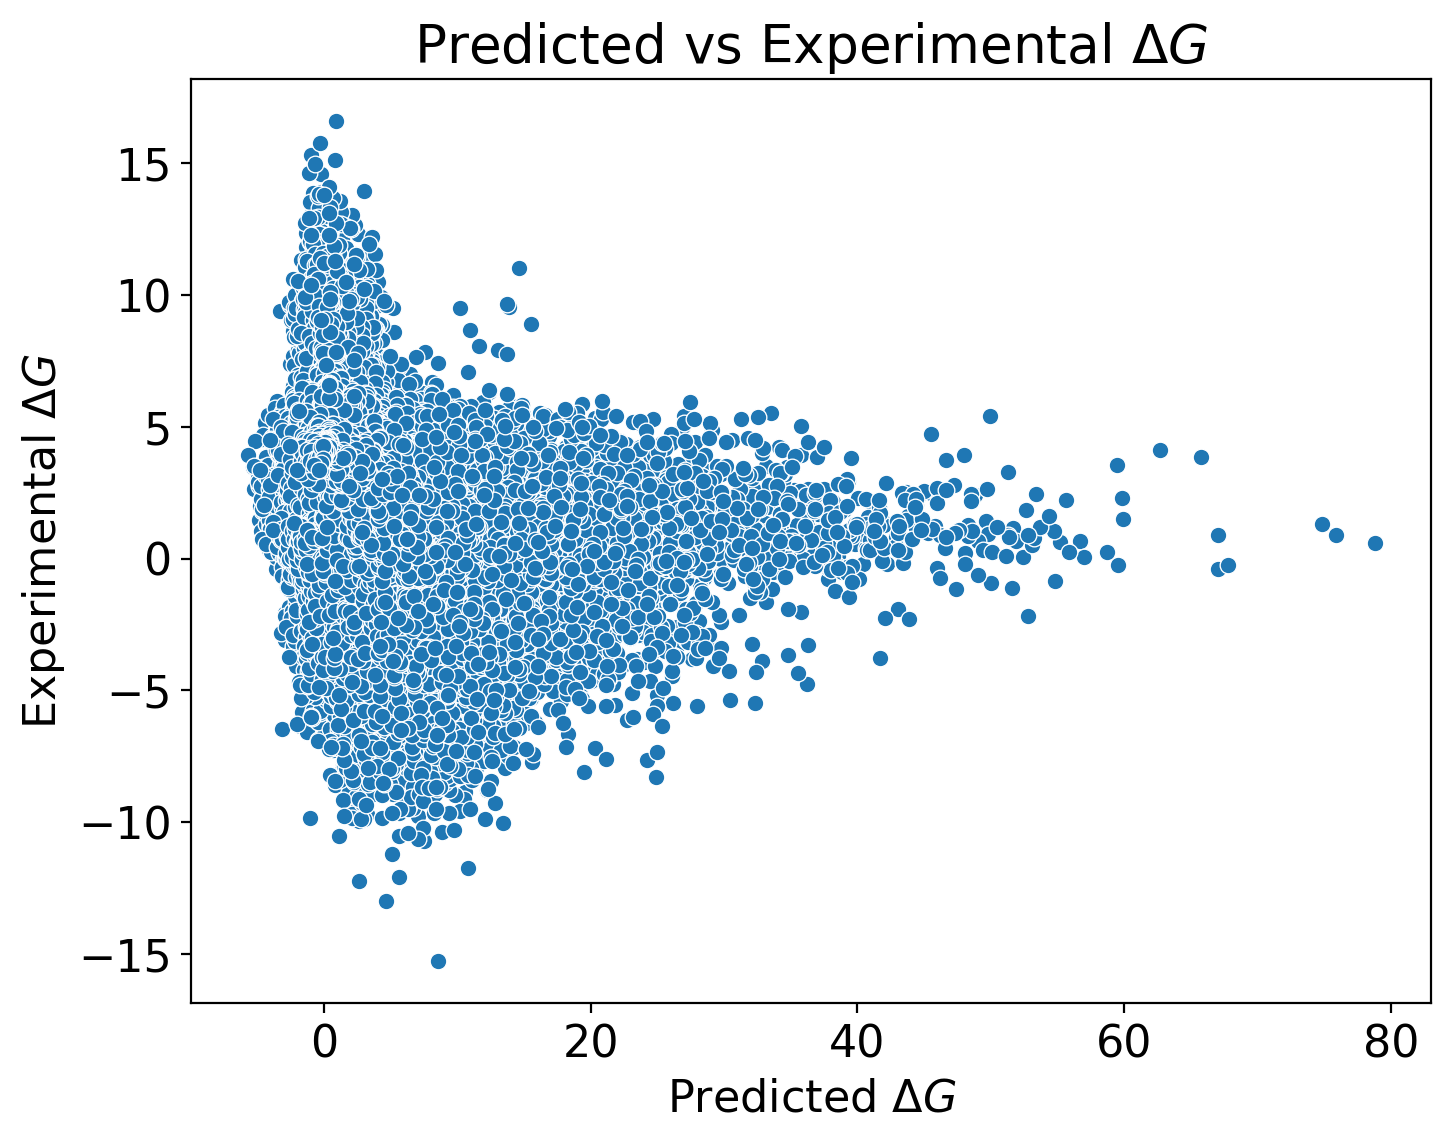

In [36]:
plt.figure(figsize=fig_size)
sns.scatterplot(x=foldx_res['pred_deltaG'], y=foldx_res['deltaG'])
plt.xlabel('Predicted $\Delta G$')
plt.ylabel('Experimental $\Delta G$')
plt.title('Predicted vs Experimental $\Delta G$')
plt.show()

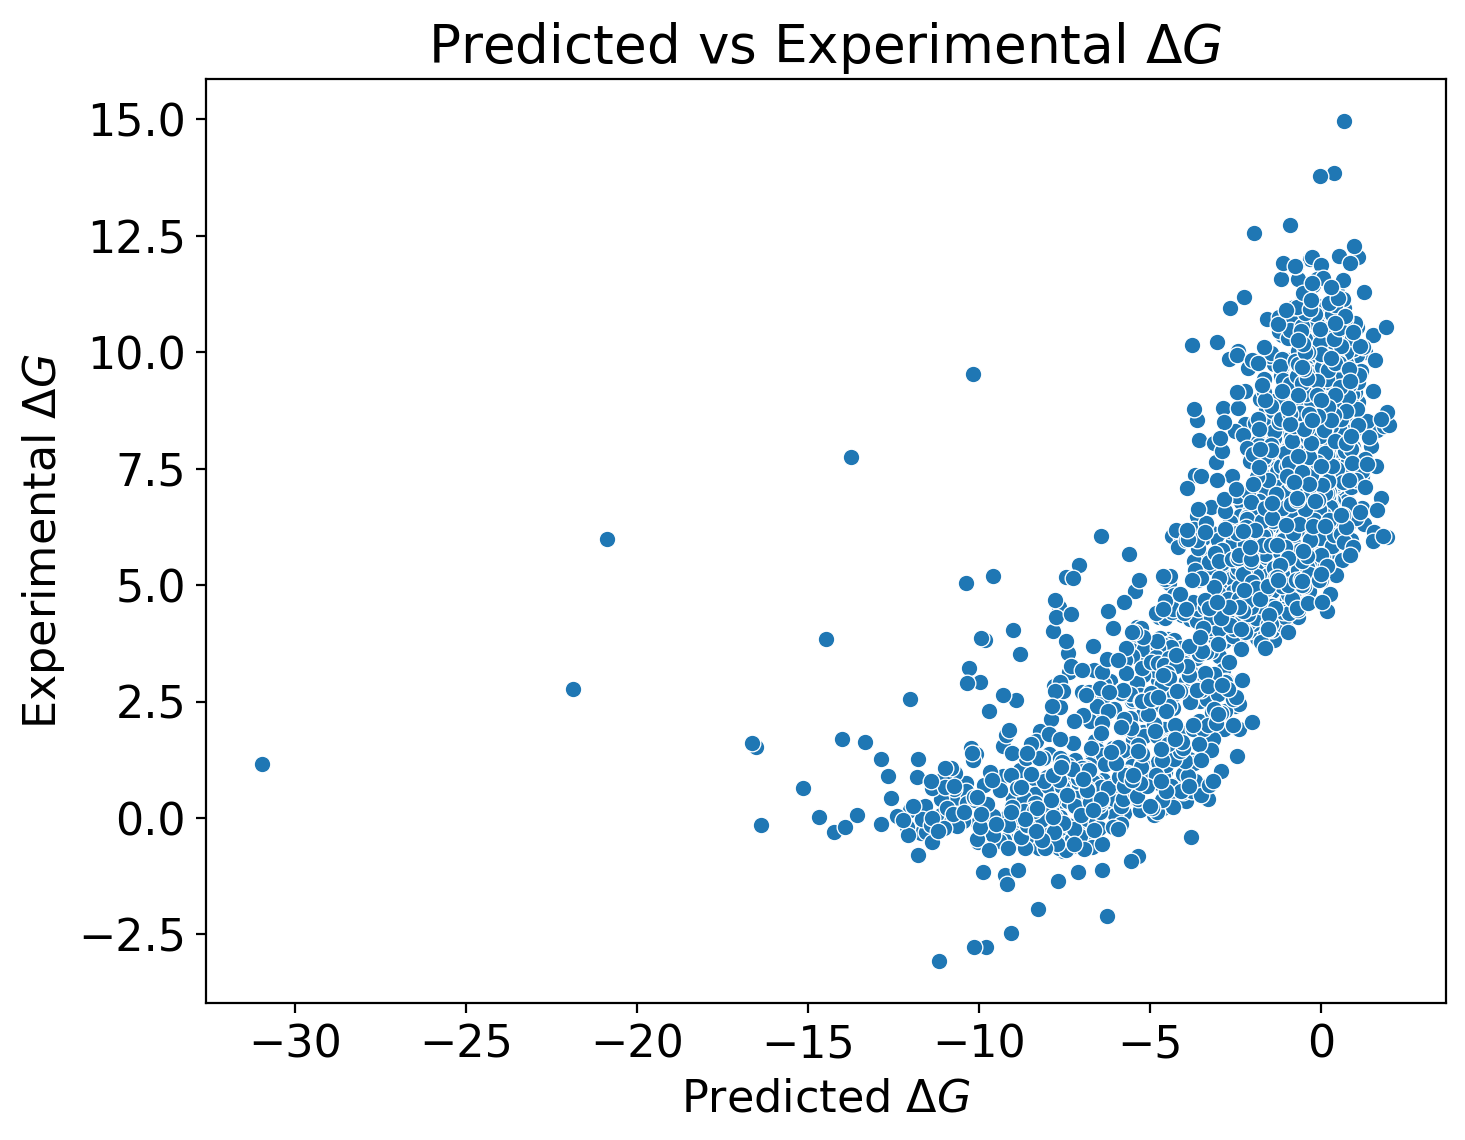

In [37]:
p1_res = foldx_res[foldx_res['protein_name'] == '6XQC']
plt.figure(figsize=fig_size)
sns.scatterplot(x=-1*p1_res['pred_deltaG'], y=p1_res['deltaG'])
plt.xlabel('Predicted $\Delta G$')
plt.ylabel('Experimental $\Delta G$')
plt.title('Predicted vs Experimental $\Delta G$')
plt.show()

# Rosetta values

In [47]:
# # Combain rosetta validation score into one dataframe
# rosetta_ds_path = "../data/Processed_K50_dG_datasets"
# rosseta_df = pd.DataFrame()
# for i in range(4):
#     rosseta_df = pd.concat([rosseta_df, pd.read_csv(f'{rosetta_ds_path}/rosetta_valid_{i+1}.csv')], axis=0)
# rosseta_df = rosseta_df.reset_index(drop=True)
# # save the combined dataframe
# rosseta_df.to_csv(f'{rosetta_ds_path}/rosetta_valid.csv', index=False)
# rosseta_df.head()

,name,pdb_path,mut_type,rosetta_wildtype,rosetta_mutant,rosetta_deltaG,deltaG,pearson,spearman
0,1A0N.pdb_L7S_V1Q,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V1Q,-145.204616,-145.163807,0.040809,2.689777,-0.154192,-0.443612
1,1A0N.pdb_L7S_V1E,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V1E,-145.204616,-144.948408,0.256208,2.636156,-0.154192,-0.443612
2,1A0N.pdb_L7S_V1N,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V1N,-145.204616,-144.861044,0.343571,2.643197,-0.154192,-0.443612
3,1A0N.pdb_L7S_V1H,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V1H,-145.204616,-143.272908,1.931708,2.655785,-0.154192,-0.443612
4,1A0N.pdb_L7S_V1D,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V1D,-145.204616,-144.702618,0.501997,2.556652,-0.154192,-0.443612


In [30]:
rosetta_results = pd.read_csv(base_pred_dir + 'rosetta_valid.csv')
rosetta_results.head()

,name,pdb_path,mut_type,rosetta_wildtype,rosetta_mutant,rosetta_deltaG,deltaG,pearson,spearman
0,1A0N.pdb_L7S_V1Q,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V1Q,-145.204616,-145.163807,0.040809,2.689777,-0.154192,-0.443612
1,1A0N.pdb_L7S_V1E,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V1E,-145.204616,-144.948408,0.256208,2.636156,-0.154192,-0.443612
2,1A0N.pdb_L7S_V1N,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V1N,-145.204616,-144.861044,0.343571,2.643197,-0.154192,-0.443612
3,1A0N.pdb_L7S_V1H,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V1H,-145.204616,-143.272908,1.931708,2.655785,-0.154192,-0.443612
4,1A0N.pdb_L7S_V1D,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V1D,-145.204616,-144.702618,0.501997,2.556652,-0.154192,-0.443612


In [31]:
ros_res = pd.DataFrame()
ros_res['mut_type'] = rosetta_results['mut_type']
ros_res['pred_deltaG'] = rosetta_results['rosetta_mutant']
ros_res['deltaG'] = rosetta_results['deltaG']
ros_res['protein_name'] = rosetta_results['name'].apply(lambda x: x.split('.')[0])
ros_res.head()

,mut_type,pred_deltaG,deltaG,protein_name
0,V1Q,-145.163807,2.689777,1A0N
1,V1E,-144.948408,2.636156,1A0N
2,V1N,-144.861044,2.643197,1A0N
3,V1H,-143.272908,2.655785,1A0N
4,V1D,-144.702618,2.556652,1A0N


In [32]:
ros_corr = pd.DataFrame()
gr_ros_res = ros_res.groupby('protein_name')
ros_corr['protein_name'] = gr_ros_res.apply(lambda x: x['protein_name'].iloc[0]).values
ros_corr['pearson_corr'] = gr_ros_res.apply(lambda x: x[['pred_deltaG', 'deltaG']].corr(method='pearson').iloc[0,1]).values
ros_corr['folded_pearson_corr'] = gr_ros_res.apply(lambda x: x[['pred_deltaG', 'deltaG']].corr().iloc[0,1]).values
ros_corr['p_values'] = gr_ros_res.apply(lambda x: pearsonr(x['pred_deltaG'], x['deltaG'])[1]).values
ros_corr['std_deltaG'] = gr_ros_res.apply(lambda x: x['deltaG'].std()).values

In [33]:
# mean and median
print('Mean pearson corr per protein: ', ros_corr['pearson_corr'].mean())
print('Median pearson corr per protein: ', ros_corr['pearson_corr'].median())
# print coorelation for all proteins
print('Pearson correlation all proteins: ', ros_res['pred_deltaG'].corr(ros_res['deltaG']))

Mean pearson corr per protein:  -0.1978605432698071
Median pearson corr per protein:  -0.19750965950856053
Pearson correlation all proteins:  -0.17666457533639193


In [38]:
len(ros_corr)

368

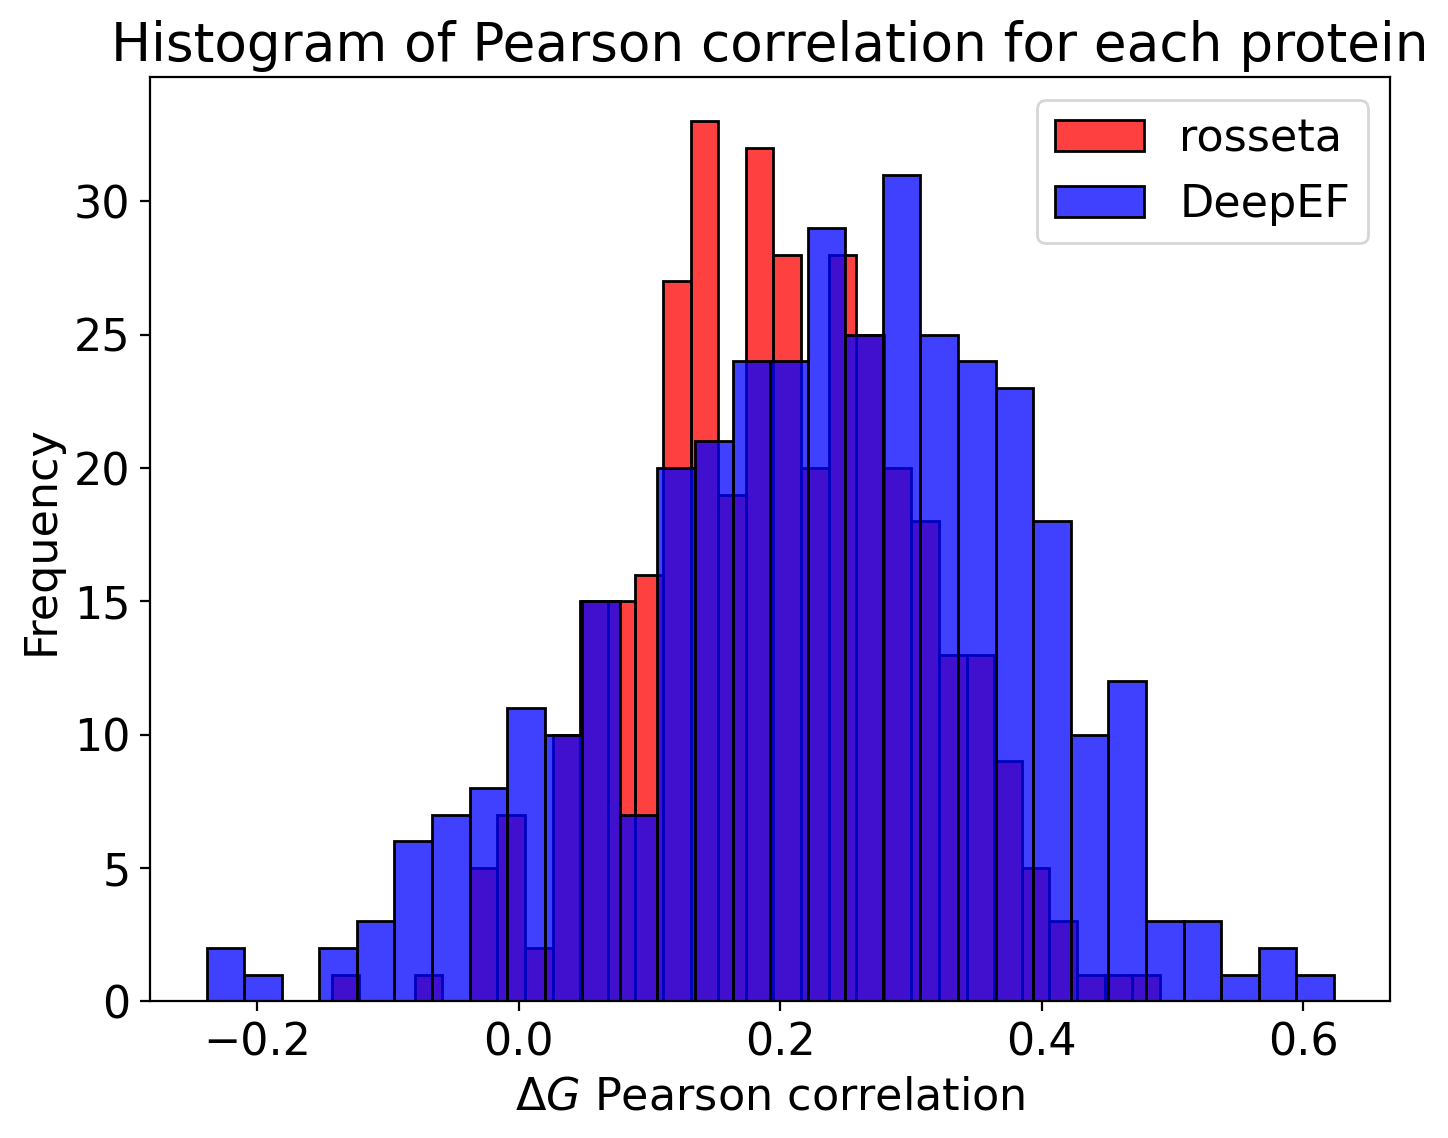

In [39]:
# plot histogram of pearson correlation
plt.figure(figsize=fig_size)
sns.histplot(ros_corr['pearson_corr']*-1,label = 'rosseta',color='red',bins=30)
sns.histplot(corr_df['pearson_corr'],label = 'DeepEF',color='blue',bins=30)
plt.xlabel('$\Delta G$ Pearson correlation')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Pearson correlation for each protein')
plt.show()

In [40]:
ros_corr

,protein_name,pearson_corr,folded_pearson_corr,p_values,std_deltaG
0,1A0N,-0.215554,-0.215554,9.444449e-29,1.196459
1,1A32,-0.346786,-0.346786,3.733106e-35,0.657804
2,1AOY,-0.277431,-0.277431,1.351016e-24,1.146556
3,1B7J,-0.279545,-0.279545,2.879102e-23,2.897572
4,1BK2,-0.133735,-0.133735,3.307315e-14,2.208767
...,...,...,...,...,...
363,v2_2LXE,-0.247272,-0.247272,1.820073e-15,1.057765
364,v2_2M5A,-0.373180,-0.373180,2.479442e-36,0.829742
365,v2_4UZX,-0.272638,-0.272638,3.099178e-20,0.940861
366,v2_5XK5,-0.274488,-0.274488,2.118126e-24,1.482221


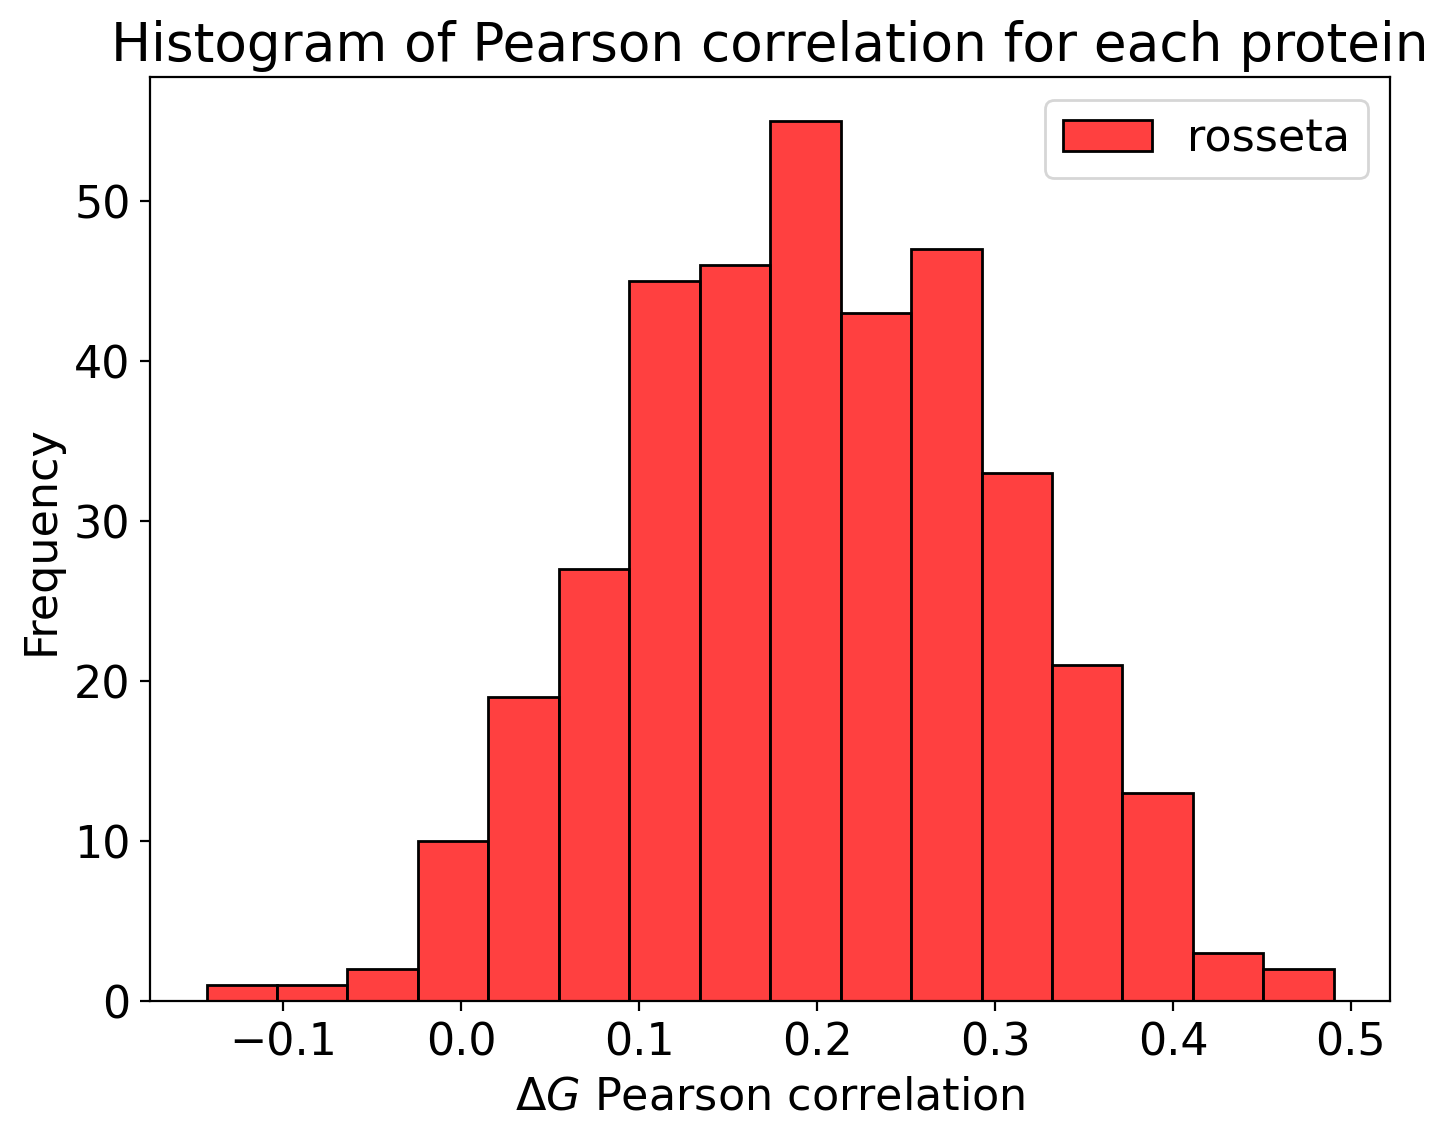

In [41]:
# plot histogram of pearson correlation
plt.figure(figsize=fig_size)
sns.histplot(ros_corr['pearson_corr']*-1,label = 'rosseta',color='red')
# sns.histplot(corr_df['pearson_corr'],label = 'DeepEF',color='blue')
plt.xlabel('$\Delta G$ Pearson correlation')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Pearson correlation for each protein')
plt.show()

# BLOSUM62 coorelation

In [42]:
blosum_path = '../data/Processed_K50_dG_datasets/blusom62_values.csv'
blosum_df = pd.read_csv(blosum_path)
blosum_df.head()

,name,pdb_path,mut_type,deltaG,Stabilizing_mut,ddg,mut_tuple,blosum62
0,1A0N.pdb_L7S_V1Q,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V1Q,2.689777,False,0.129580,"[('V', '1', 'Q')]",-2.0
1,1A0N.pdb_L7S_V1E,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V1E,2.636156,False,0.075959,"[('V', '1', 'E')]",-2.0
2,1A0N.pdb_L7S_V1N,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V1N,2.643197,False,0.082999,"[('V', '1', 'N')]",-3.0
3,1A0N.pdb_L7S_V1H,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V1H,2.655785,False,0.095588,"[('V', '1', 'H')]",-3.0
4,1A0N.pdb_L7S_V1D,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V1D,2.556652,False,-0.003546,"[('V', '1', 'D')]",-3.0


In [43]:
blosum_df['protein_name'] = blosum_df['name'].apply(lambda x: x.split('.')[0])
blosum_df

,name,pdb_path,mut_type,deltaG,Stabilizing_mut,ddg,mut_tuple,blosum62,protein_name
0,1A0N.pdb_L7S_V1Q,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V1Q,2.689777,False,0.129580,"[('V', '1', 'Q')]",-2.0,1A0N
1,1A0N.pdb_L7S_V1E,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V1E,2.636156,False,0.075959,"[('V', '1', 'E')]",-2.0,1A0N
2,1A0N.pdb_L7S_V1N,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V1N,2.643197,False,0.082999,"[('V', '1', 'N')]",-3.0,1A0N
3,1A0N.pdb_L7S_V1H,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V1H,2.655785,False,0.095588,"[('V', '1', 'H')]",-3.0,1A0N
4,1A0N.pdb_L7S_V1D,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V1D,2.556652,False,-0.003546,"[('V', '1', 'D')]",-3.0,1A0N
...,...,...,...,...,...,...,...,...,...
101788,1W4H.pdb_A44W,./data/Processed_K50_dG_datasets/AlphaFold_mod...,A44W,3.343075,-,0.398116,"[('A', '44', 'W')]",-3.0,1W4H
101789,1W4H.pdb_A44Y,./data/Processed_K50_dG_datasets/AlphaFold_mod...,A44Y,3.397988,-,0.453029,"[('A', '44', 'Y')]",-2.0,1W4H
101790,1W4H.pdb_A44F,./data/Processed_K50_dG_datasets/AlphaFold_mod...,A44F,3.440939,-,0.495980,"[('A', '44', 'F')]",-2.0,1W4H
101791,1W4H.pdb_A44P,./data/Processed_K50_dG_datasets/AlphaFold_mod...,A44P,2.721260,-,-0.223699,"[('A', '44', 'P')]",-1.0,1W4H


In [44]:
blosum_df['Stabilizing_mut'].unique()

array(['False', '-', 'True'], dtype=object)

In [45]:
blosum_df[['ddg','blosum62']].corr(method='pearson')

,ddg,blosum62
ddg,1.000000,0.158919
blosum62,0.158919,1.000000


In [46]:
print(len(blosum_df.groupby('pdb_path')))

57


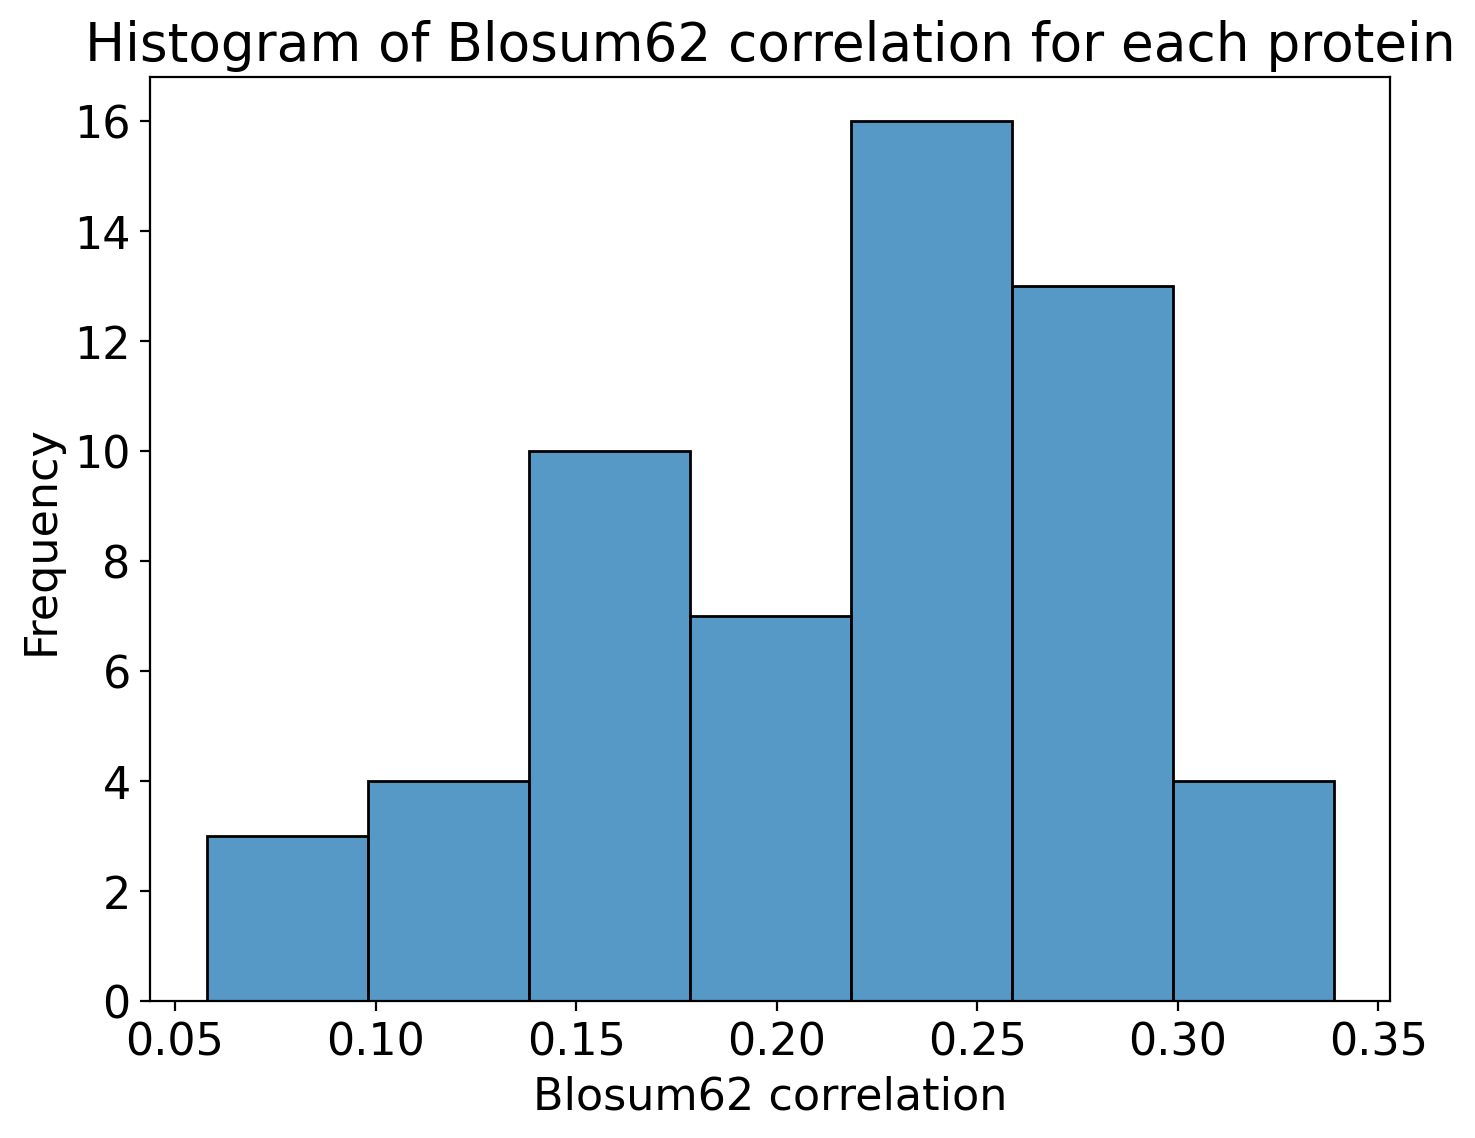

In [47]:
blosum_protein_corr = blosum_df.groupby('protein_name')[['ddg','blosum62']].corr(method='pearson').reset_index()
# get from gropby 2 colums ddg and blosum62
blosum_protein_corr = blosum_protein_corr[blosum_protein_corr['level_1'] == 'ddg']
blosum_protein_corr = blosum_protein_corr.drop(['level_1'], axis=1)
blosum_protein_corr.head()

plt.figure(figsize=fig_size)
sns.histplot(blosum_protein_corr['blosum62'])
plt.xlabel('Blosum62 correlation')
plt.ylabel('Frequency')
plt.title('Histogram of Blosum62 correlation for each protein')
plt.show()

In [48]:
# mean and std of blosum62 correlation
mean_blosum62 = blosum_protein_corr['blosum62'].mean()
std_blosum62 = blosum_protein_corr['blosum62'].std()
print(f"Mean blosum62 correlation: {mean_blosum62}, std blosum62 correlation: {std_blosum62}")

Mean blosum62 correlation: 0.21855548698379604, std blosum62 correlation: 0.0638107094433902


In [49]:
# Add std per protein
blosum_protein_corr['std_ddg'] = blosum_df.groupby('protein_name')['ddg'].std().values

In [50]:
blosum_protein_corr['blosum62'].argmax()

56

In [51]:
# get 193 protein with blosum62 correlation
blosum_protein_corr[193:194]

,protein_name,ddg,blosum62,std_ddg


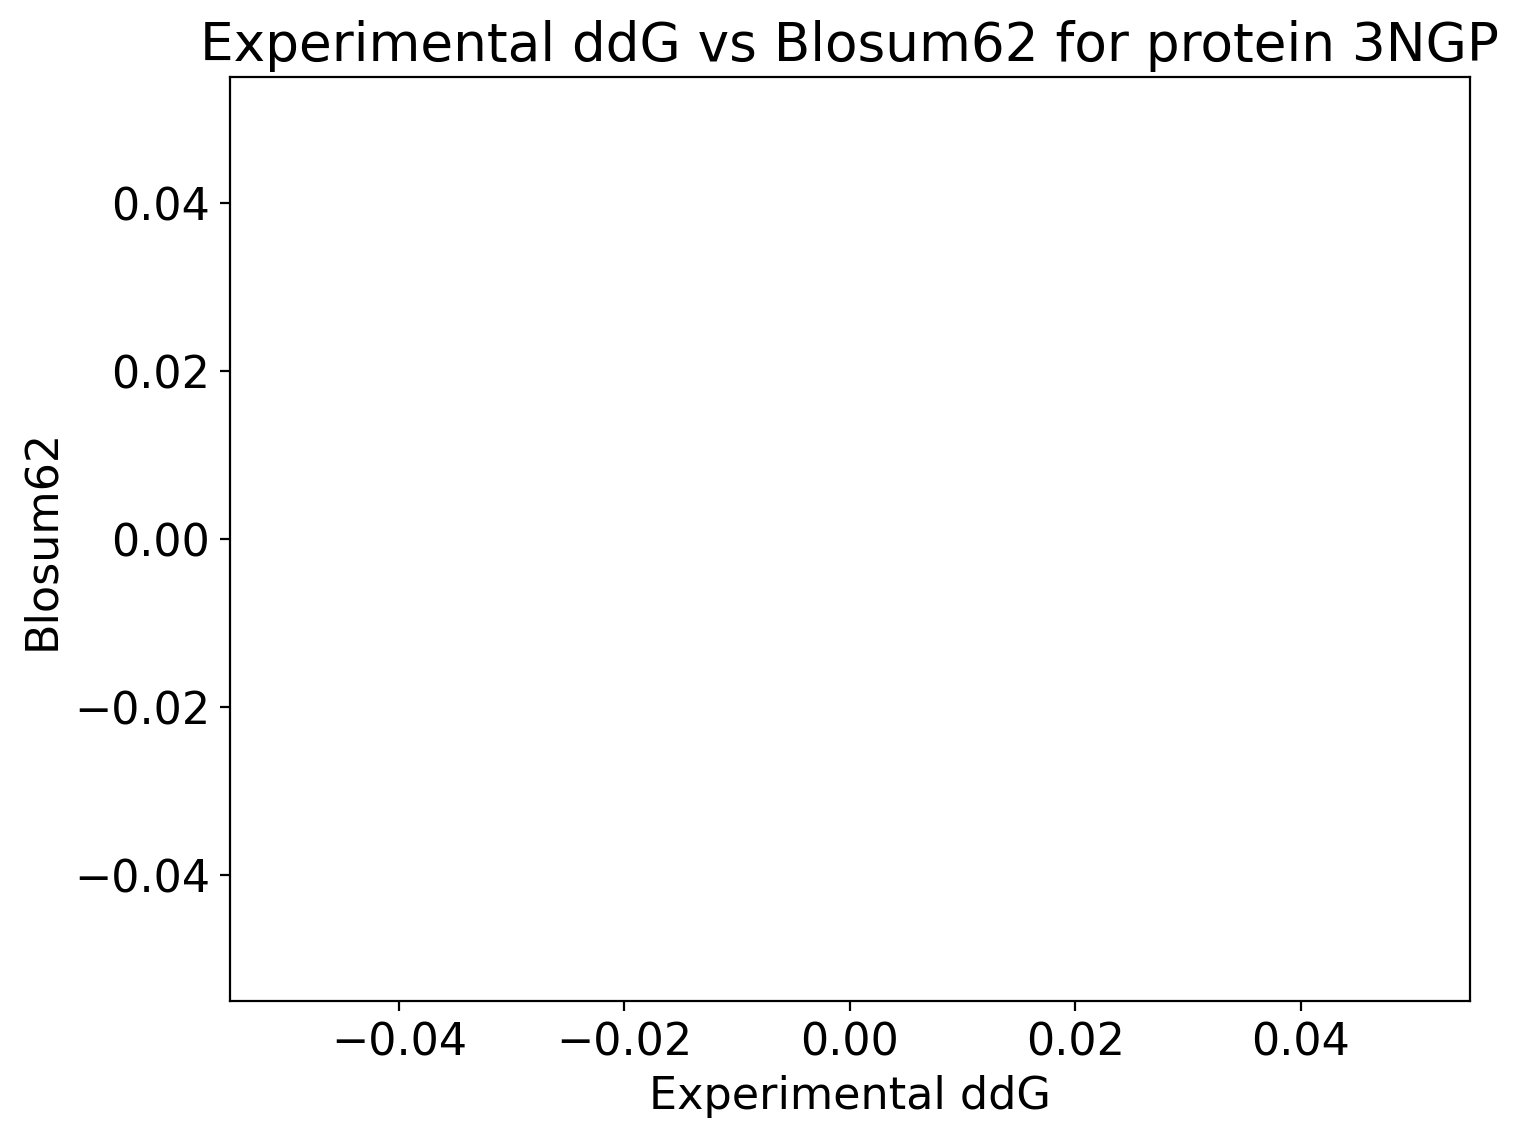

In [52]:
a0n_df = blosum_df[blosum_df['protein_name'] == '3NGP']
plt.figure(figsize=fig_size)
plt.scatter(a0n_df['ddg'], a0n_df['blosum62'])
plt.xlabel('Experimental ddG')
plt.ylabel('Blosum62')
plt.title('Experimental ddG vs Blosum62 for protein 3NGP')
plt.show()

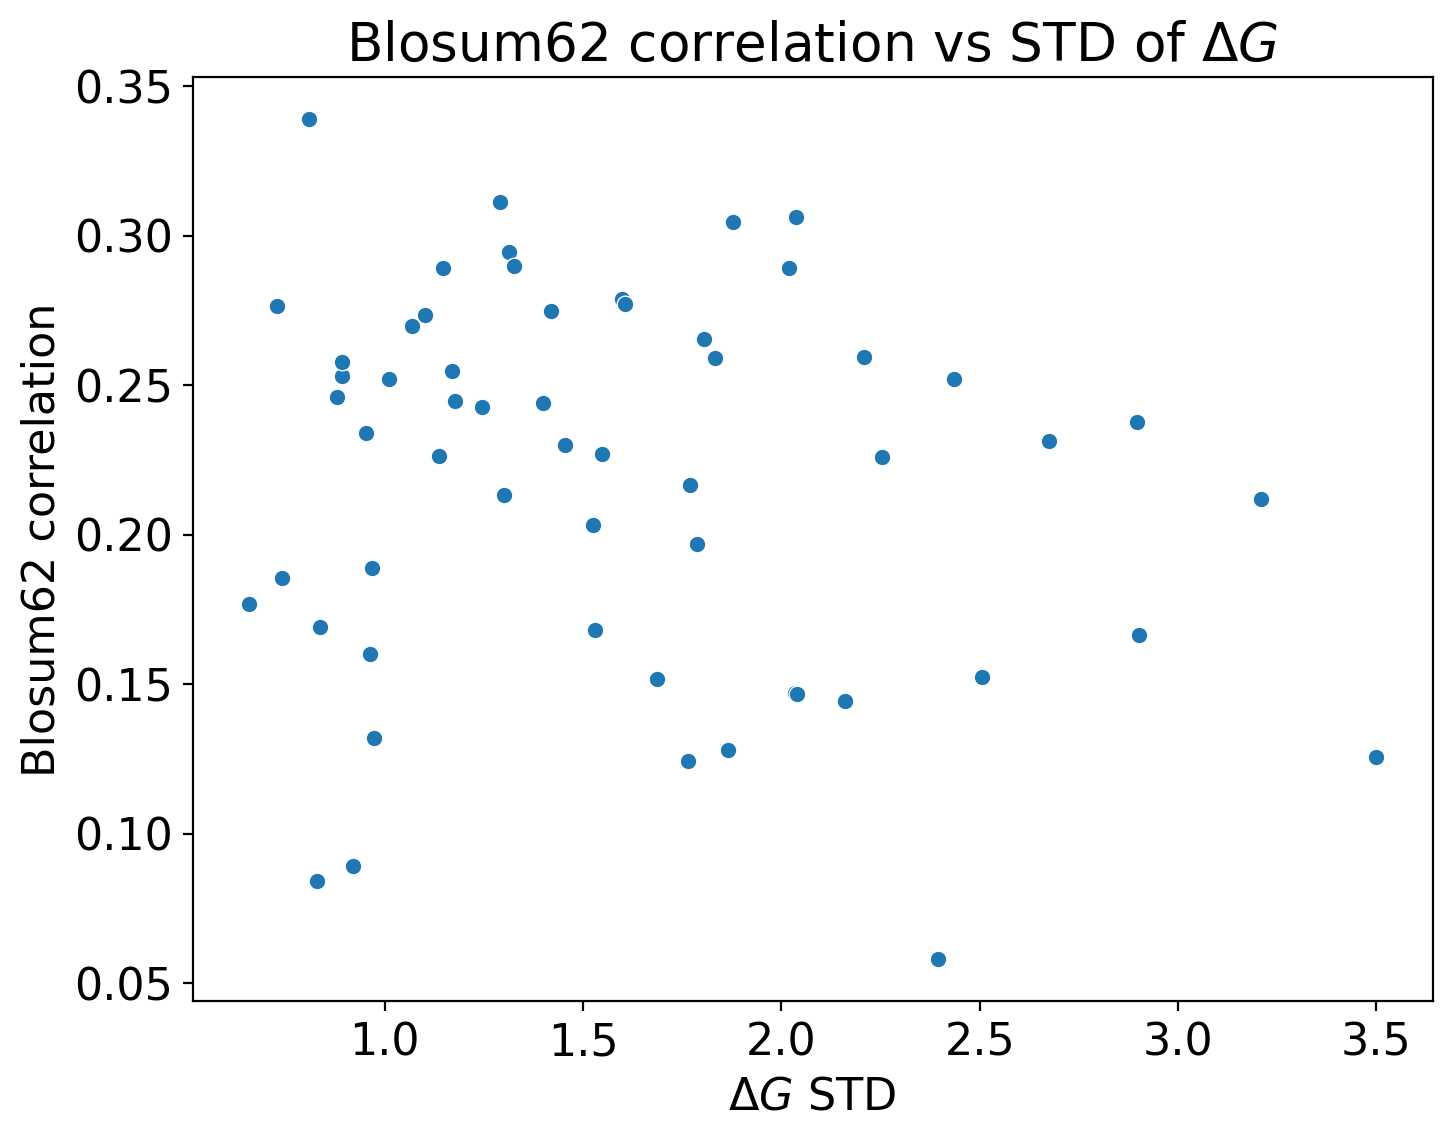

In [53]:
# coorelation vs std of blosum62
plt.figure(figsize=fig_size)
sns.scatterplot(x=blosum_protein_corr['std_ddg'], y=blosum_protein_corr['blosum62'])
plt.xlabel('$\Delta G$ STD')
plt.ylabel('Blosum62 correlation')
plt.title('Blosum62 correlation vs STD of $\Delta G$')
plt.show()

$\Delta G = E_{unfolded} - E_{folded} $

$\Delta \Delta G = \Delta G -  \Delta G_{WT}$

As big as the $|\Delta G|$ we know that the protein is more stable.

In [54]:
blosum_df

,name,pdb_path,mut_type,deltaG,Stabilizing_mut,ddg,mut_tuple,blosum62,protein_name
0,1A0N.pdb_L7S_V1Q,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V1Q,2.689777,False,0.129580,"[('V', '1', 'Q')]",-2.0,1A0N
1,1A0N.pdb_L7S_V1E,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V1E,2.636156,False,0.075959,"[('V', '1', 'E')]",-2.0,1A0N
2,1A0N.pdb_L7S_V1N,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V1N,2.643197,False,0.082999,"[('V', '1', 'N')]",-3.0,1A0N
3,1A0N.pdb_L7S_V1H,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V1H,2.655785,False,0.095588,"[('V', '1', 'H')]",-3.0,1A0N
4,1A0N.pdb_L7S_V1D,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V1D,2.556652,False,-0.003546,"[('V', '1', 'D')]",-3.0,1A0N
...,...,...,...,...,...,...,...,...,...
101788,1W4H.pdb_A44W,./data/Processed_K50_dG_datasets/AlphaFold_mod...,A44W,3.343075,-,0.398116,"[('A', '44', 'W')]",-3.0,1W4H
101789,1W4H.pdb_A44Y,./data/Processed_K50_dG_datasets/AlphaFold_mod...,A44Y,3.397988,-,0.453029,"[('A', '44', 'Y')]",-2.0,1W4H
101790,1W4H.pdb_A44F,./data/Processed_K50_dG_datasets/AlphaFold_mod...,A44F,3.440939,-,0.495980,"[('A', '44', 'F')]",-2.0,1W4H
101791,1W4H.pdb_A44P,./data/Processed_K50_dG_datasets/AlphaFold_mod...,A44P,2.721260,-,-0.223699,"[('A', '44', 'P')]",-1.0,1W4H


In [55]:
blosum_df['1aa'] = blosum_df['mut_type'].apply(lambda x: x[0])
blosum_df['2aa'] = blosum_df['mut_type'].apply(lambda x: x[-1])
blosum_df

,name,pdb_path,mut_type,deltaG,Stabilizing_mut,ddg,mut_tuple,blosum62,protein_name,1aa,2aa
0,1A0N.pdb_L7S_V1Q,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V1Q,2.689777,False,0.129580,"[('V', '1', 'Q')]",-2.0,1A0N,V,Q
1,1A0N.pdb_L7S_V1E,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V1E,2.636156,False,0.075959,"[('V', '1', 'E')]",-2.0,1A0N,V,E
2,1A0N.pdb_L7S_V1N,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V1N,2.643197,False,0.082999,"[('V', '1', 'N')]",-3.0,1A0N,V,N
3,1A0N.pdb_L7S_V1H,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V1H,2.655785,False,0.095588,"[('V', '1', 'H')]",-3.0,1A0N,V,H
4,1A0N.pdb_L7S_V1D,./data/Processed_K50_dG_datasets/AlphaFold_mod...,V1D,2.556652,False,-0.003546,"[('V', '1', 'D')]",-3.0,1A0N,V,D
...,...,...,...,...,...,...,...,...,...,...,...
101788,1W4H.pdb_A44W,./data/Processed_K50_dG_datasets/AlphaFold_mod...,A44W,3.343075,-,0.398116,"[('A', '44', 'W')]",-3.0,1W4H,A,W
101789,1W4H.pdb_A44Y,./data/Processed_K50_dG_datasets/AlphaFold_mod...,A44Y,3.397988,-,0.453029,"[('A', '44', 'Y')]",-2.0,1W4H,A,Y
101790,1W4H.pdb_A44F,./data/Processed_K50_dG_datasets/AlphaFold_mod...,A44F,3.440939,-,0.495980,"[('A', '44', 'F')]",-2.0,1W4H,A,F
101791,1W4H.pdb_A44P,./data/Processed_K50_dG_datasets/AlphaFold_mod...,A44P,2.721260,-,-0.223699,"[('A', '44', 'P')]",-1.0,1W4H,A,P


In [56]:
blosum_df[(blosum_df['1aa'] == 'W') & (blosum_df['2aa'] == 'K')]

,name,pdb_path,mut_type,deltaG,Stabilizing_mut,ddg,mut_tuple,blosum62,protein_name,1aa,2aa
664,1A0N.pdb_L7S_W36K,./data/Processed_K50_dG_datasets/AlphaFold_mod...,W36K,2.310537,False,-0.249661,"[('W', '36', 'K')]",-3.0,1A0N,W,K
683,1A0N.pdb_L7S_W37K,./data/Processed_K50_dG_datasets/AlphaFold_mod...,W37K,0.080266,False,-2.479931,"[('W', '37', 'K')]",-3.0,1A0N,W,K
1768,1A0N.pdb_V55A_W36K,./data/Processed_K50_dG_datasets/AlphaFold_mod...,W36K,2.809018,False,0.248821,"[('W', '36', 'K')]",-3.0,1A0N,W,K
1787,1A0N.pdb_V55A_W37K,./data/Processed_K50_dG_datasets/AlphaFold_mod...,W37K,0.695373,False,-1.864825,"[('W', '37', 'K')]",-3.0,1A0N,W,K
6593,1BK2.pdb_F47A_W36K,./data/Processed_K50_dG_datasets/AlphaFold_mod...,W36K,-0.595545,False,-3.006505,"[('W', '36', 'K')]",-3.0,1BK2,W,K
...,...,...,...,...,...,...,...,...,...,...,...
98304,1V1C.pdb_W39K,./data/Processed_K50_dG_datasets/AlphaFold_mod...,W39K,-2.367788,False,-5.827731,"[('W', '39', 'K')]",-3.0,1V1C,W,K
98608,1V1C.pdb_W55K,./data/Processed_K50_dG_datasets/AlphaFold_mod...,W55K,0.796409,False,-2.663534,"[('W', '55', 'K')]",-3.0,1V1C,W,K
99243,1VII.pdb_W24K,./data/Processed_K50_dG_datasets/AlphaFold_mod...,W24K,1.480566,False,-0.841175,"[('W', '24', 'K')]",-3.0,1VII,W,K
100125,1W4F.pdb_W39K,./data/Processed_K50_dG_datasets/AlphaFold_mod...,W39K,2.739830,False,-1.044574,"[('W', '39', 'K')]",-3.0,1W4F,W,K


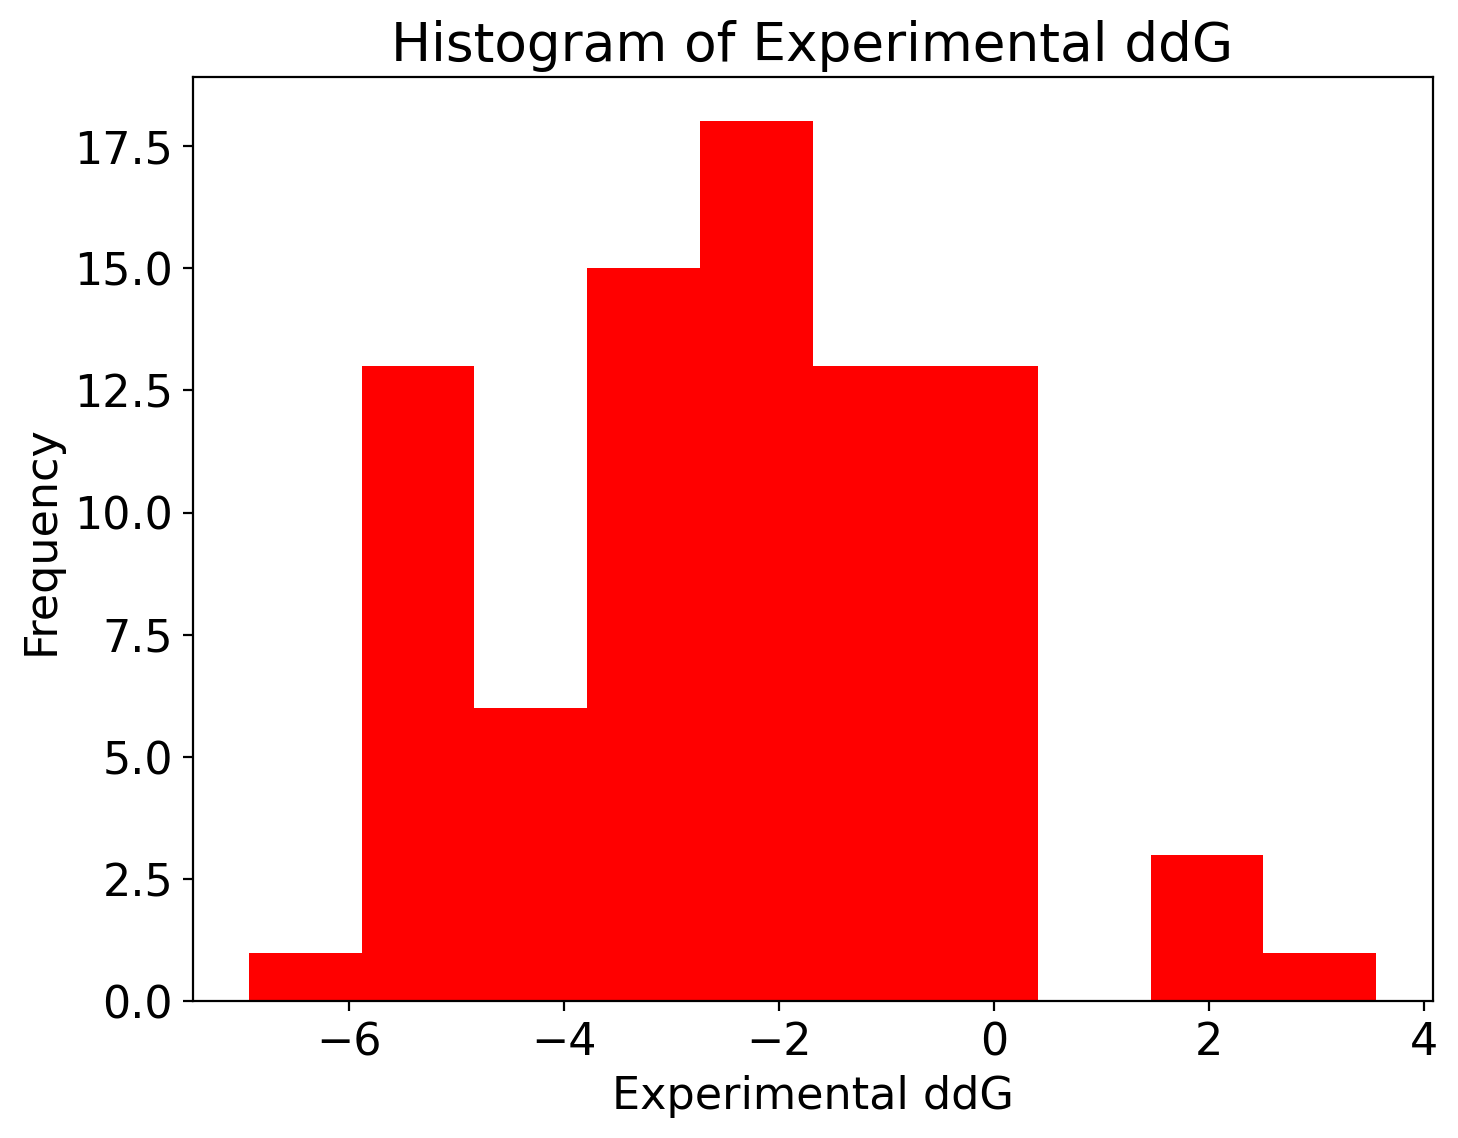

In [57]:
plt.figure(figsize=fig_size)
# plt.hist(blosum_df['ddg'], bins=200)
plt.hist(blosum_df[(blosum_df['1aa'] == 'W') & (blosum_df['2aa'] == 'K')]['ddg'], bins=10,color='red')
plt.xlabel('Experimental ddG')
plt.ylabel('Frequency')
plt.title('Histogram of Experimental ddG')
plt.show()

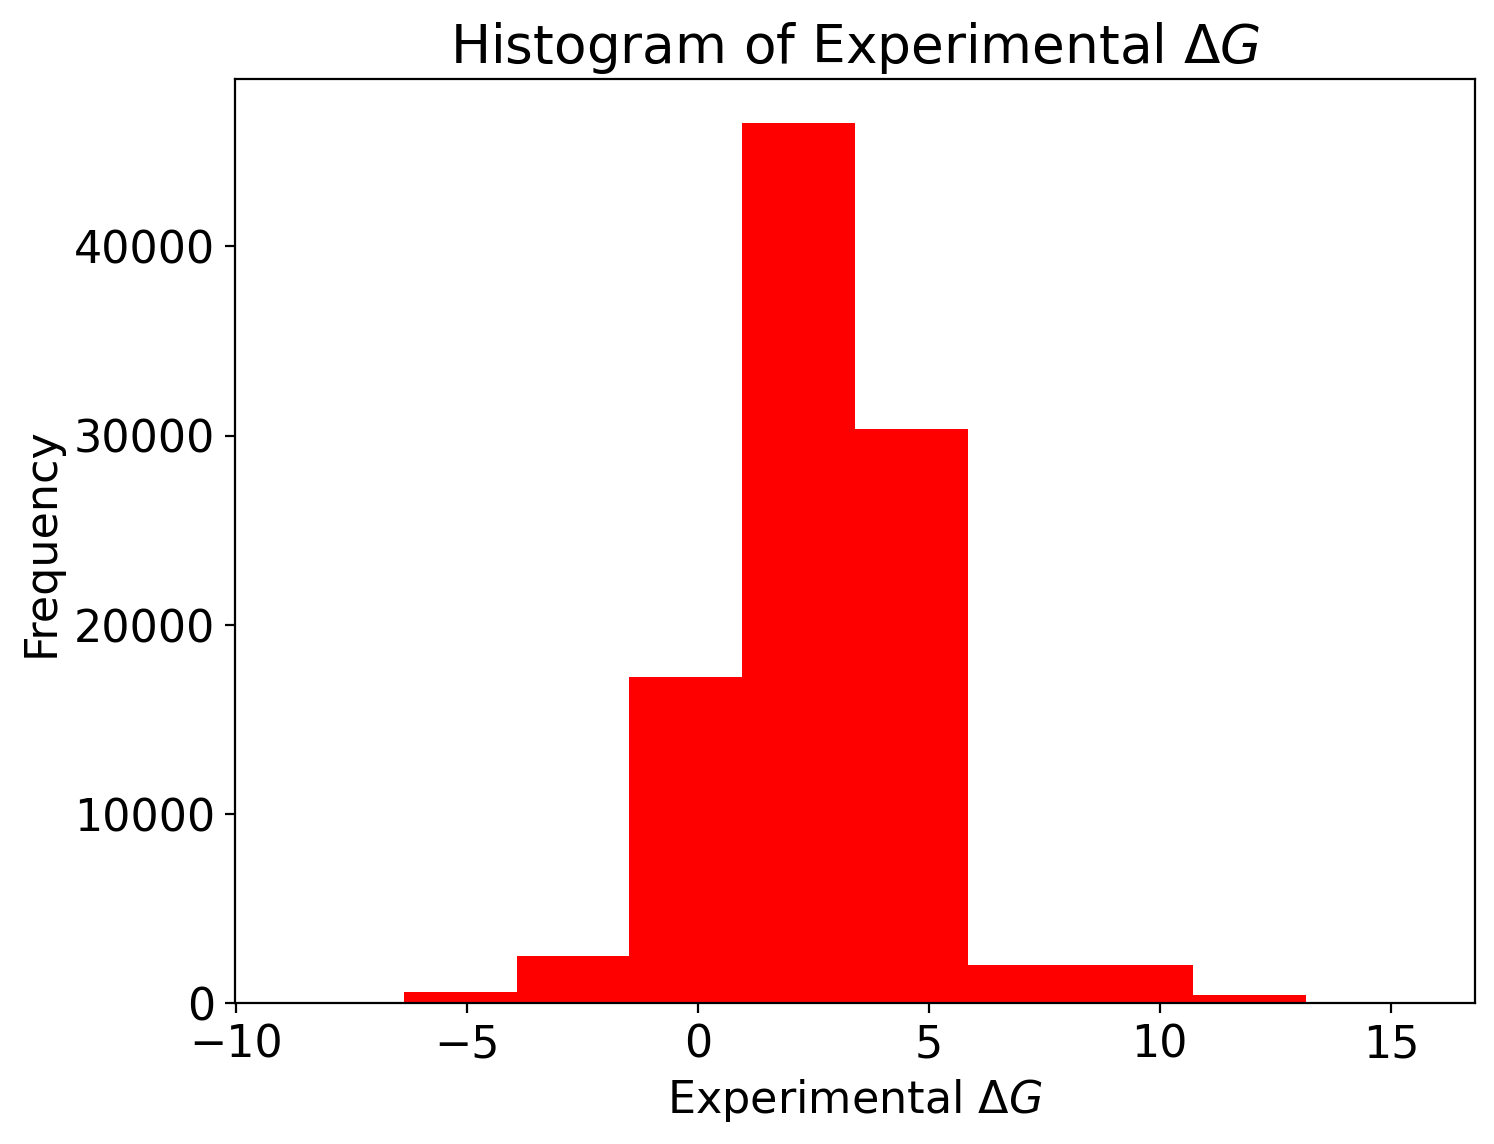

In [58]:
plt.figure(figsize=fig_size)
plt.hist(blosum_df['deltaG'], bins=10,color='red')
plt.xlabel('Experimental $\Delta G$')
plt.ylabel('Frequency')
plt.title('Histogram of Experimental $\Delta G$')
plt.show()

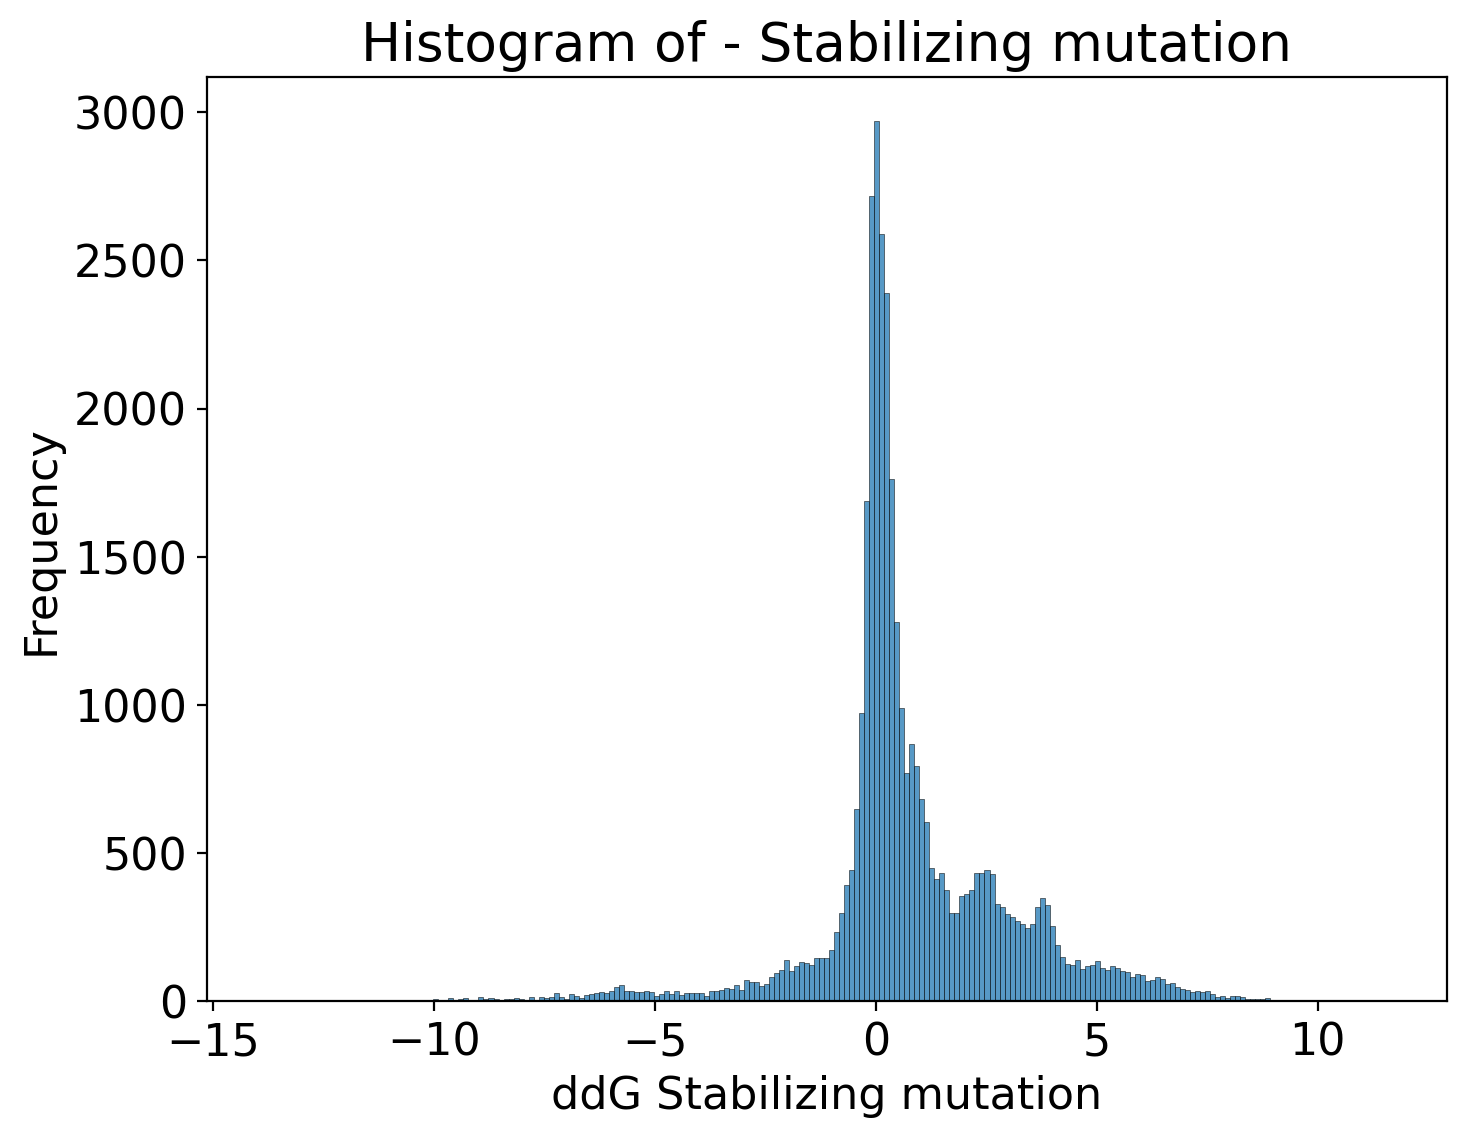

In [59]:
# plot hist of stabilizing_mut
stable = '-'
plt.figure(figsize=fig_size)
sns.histplot(blosum_df[blosum_df['Stabilizing_mut']==stable]['ddg'])
plt.xlabel('ddG Stabilizing mutation')
plt.ylabel('Frequency')
plt.title(f'Histogram of {stable} Stabilizing mutation')
plt.show()


# Base model plots

In [60]:
train_df = pd.read_csv('../res/trianed_models-cycle2_5/evaluation_results_dataset_training.csv')
val_df = pd.read_csv('../res/trianed_models-cycle2_5/evaluation_results_dataset_validation.csv')
display(train_df)
display(val_df)

,protein_id,Ejf,Eju,Exd,Ecd,Exdu,Ecy1,Ecy2,Ecy3,Ecy4,loss,lossd,lossg,lossc
0,3BM7_1_A,-41.412666,1.210083,6.554447,7.656404,0.088258,14.363352,8.834108,10.318999,5.888835,-18.966599,-43.895153,0.0,24.928555
1,2D6Y_d2d6ya1,-27.726269,-0.641665,5.556715,1.156423,-3.466122,7.996444,-5.226167,4.264071,4.640426,-16.210659,-26.703526,0.0,10.492866
2,3NIV_d3nivd1,-19.248713,2.152787,8.201568,8.957499,0.354854,0.373409,0.296913,9.085759,13.828856,-14.202070,-23.055311,0.0,8.853241
3,4UHP_d4uhpf1,-41.496311,-1.155744,10.389309,8.171604,-0.422398,5.632416,1.798253,5.289814,2.973650,-19.724230,-41.612602,0.0,21.888372
4,4ZDE_d4zdea-,-45.286003,0.111268,5.686179,13.705809,-1.255858,6.829746,6.630347,6.991740,4.982130,-19.864986,-46.941727,0.0,27.076740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100082,1BLN_d1blnc1,-41.159500,-0.491732,4.499800,4.773074,-0.686907,8.061317,4.236060,7.218131,4.112117,-19.726107,-40.723759,0.0,20.997652
100083,4UAX_1_A,-43.087700,-2.108433,4.965361,12.650717,0.758371,4.574492,12.040394,2.016724,3.304693,-19.481003,-44.227127,0.0,24.746124
100084,2O3B_1_A,-44.892448,-1.774206,6.390525,6.740859,-3.082276,3.734115,3.016077,3.334157,1.562865,-19.322405,-43.220825,0.0,23.898420
100085,1RLK_1_A,-42.736618,0.603697,4.420863,9.073440,0.066312,1.717459,-0.352922,4.464277,7.954953,-19.550213,-41.938480,0.0,22.388268


,protein_id,Ejf,Eju,Exd,Ecd,Exdu,Ecy1,Ecy2,Ecy3,Ecy4,loss,lossd,lossg,lossc
0,10#3LM3_1_A,-43.077850,0.514594,5.265057,16.074951,-0.241122,5.820592,5.355580,4.687627,4.801064,-19.956041,-44.953094,0.0,24.997053
1,10#1WAZ_1_A,0.710642,-3.970699,3.041002,5.391320,-3.116357,0.003460,3.384948,-7.710649,-2.953555,1.402583,-0.196669,0.0,1.599252
2,50#3ZJC_1_A,-53.950993,-1.444986,3.961429,17.133526,-0.274972,2.872454,9.190847,-0.713877,-2.839231,-16.122593,-53.049454,0.0,36.926861
3,50#3RCP_1_A,-39.151497,0.016677,5.392282,18.622913,1.177743,10.277054,-1.661547,6.806374,7.225792,-18.895681,-42.418282,0.0,23.522600
4,20#3S0X_1_A,-26.677555,-0.465602,5.203781,5.174927,0.785276,-3.101509,-4.663766,7.404089,7.992790,-16.058128,-26.241016,0.0,10.182888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,20#1JEG_2_B,-1.619410,-2.205095,6.828994,5.035374,5.158291,-0.473881,6.895872,2.910040,9.107167,-3.109135,-5.834352,0.0,2.725217
156,10#1HF2_1_A,-40.554646,-3.834455,2.237683,1.284628,-0.282752,6.475180,7.369308,3.840530,-0.427742,-18.495705,-38.243340,0.0,19.747635
157,20#4ZBH_1_A,-40.629997,1.969584,13.347588,10.655331,2.439743,9.007809,9.570798,8.633584,2.610902,-19.095652,-43.611416,0.0,24.515764
158,40#3BJE_1_A,-46.396908,0.592156,7.974743,15.670531,-0.588736,3.220481,9.228892,3.730506,3.055240,-19.234745,-47.916161,0.0,28.681416


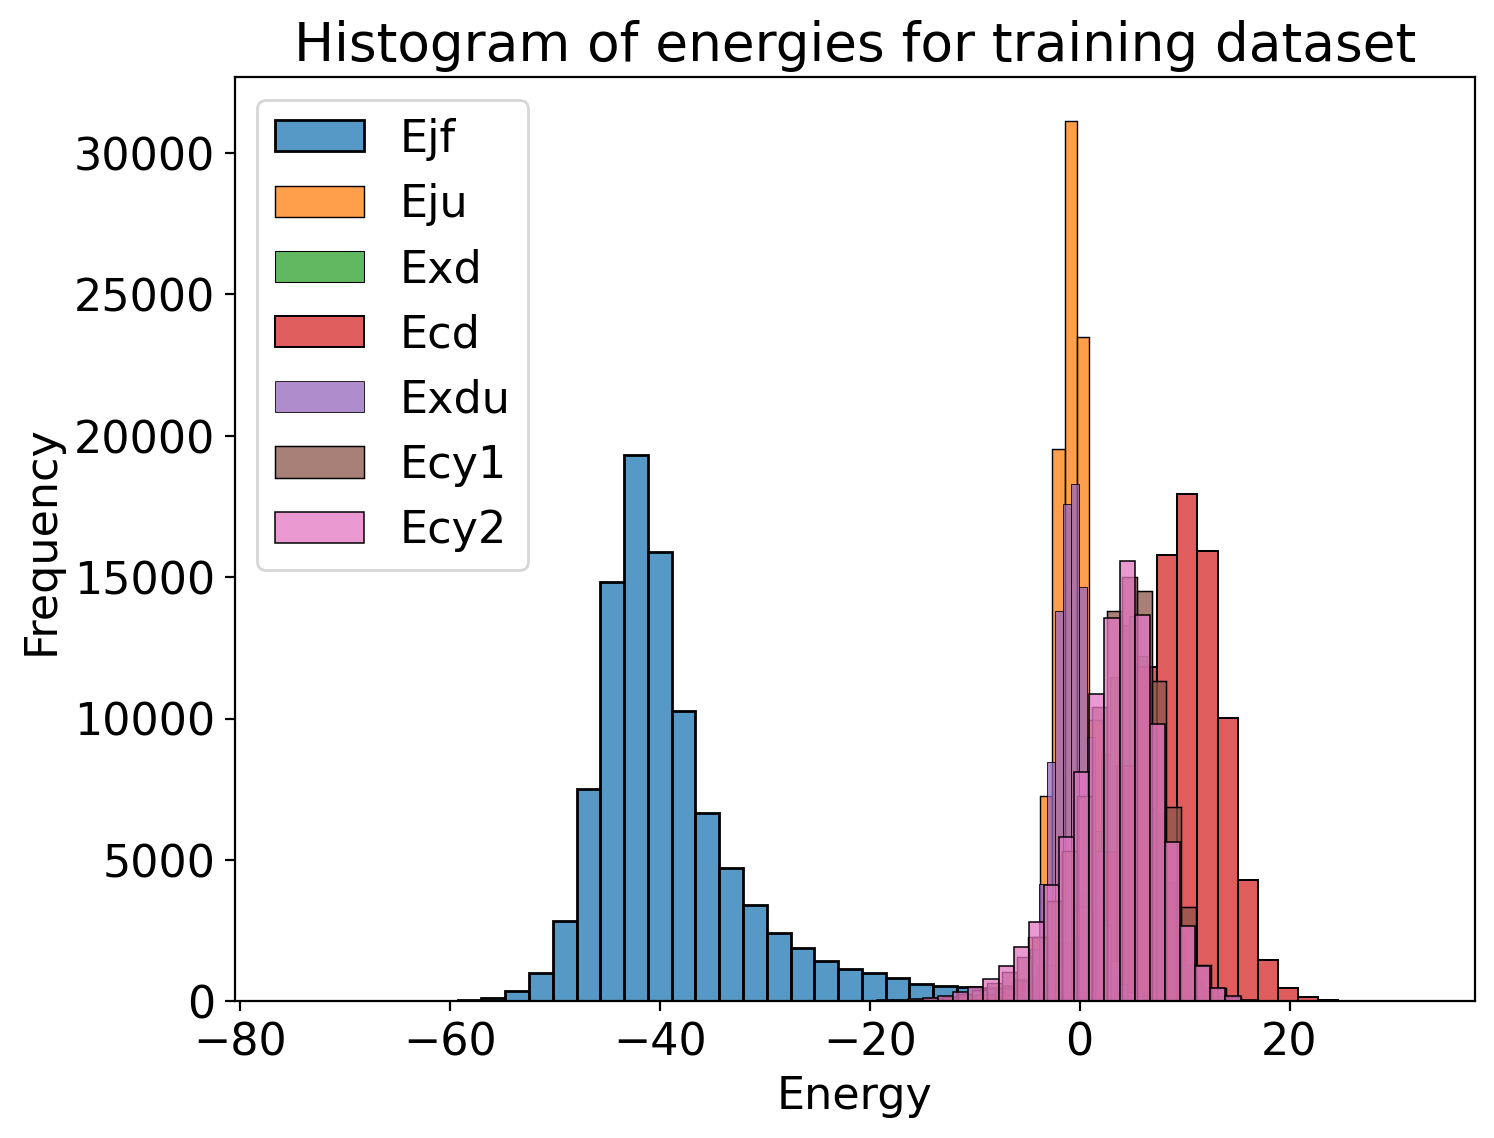

In [61]:
bins = 40
plt.figure(figsize=fig_size)
sns.histplot(train_df['Ejf'], bins=bins, label='Ejf')
sns.histplot(train_df['Eju'], bins=bins, label='Eju')
sns.histplot(train_df['Exd'], bins=bins, label='Exd')
sns.histplot(train_df['Ecd'], bins=bins, label='Ecd')
sns.histplot(train_df['Exdu'], bins=bins, label='Exdu')
sns.histplot(train_df['Ecy1'], bins=bins, label='Ecy1')
sns.histplot(train_df['Ecy2'], bins=bins, label='Ecy2')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.title('Histogram of energies for training dataset')
plt.legend()
plt.show()

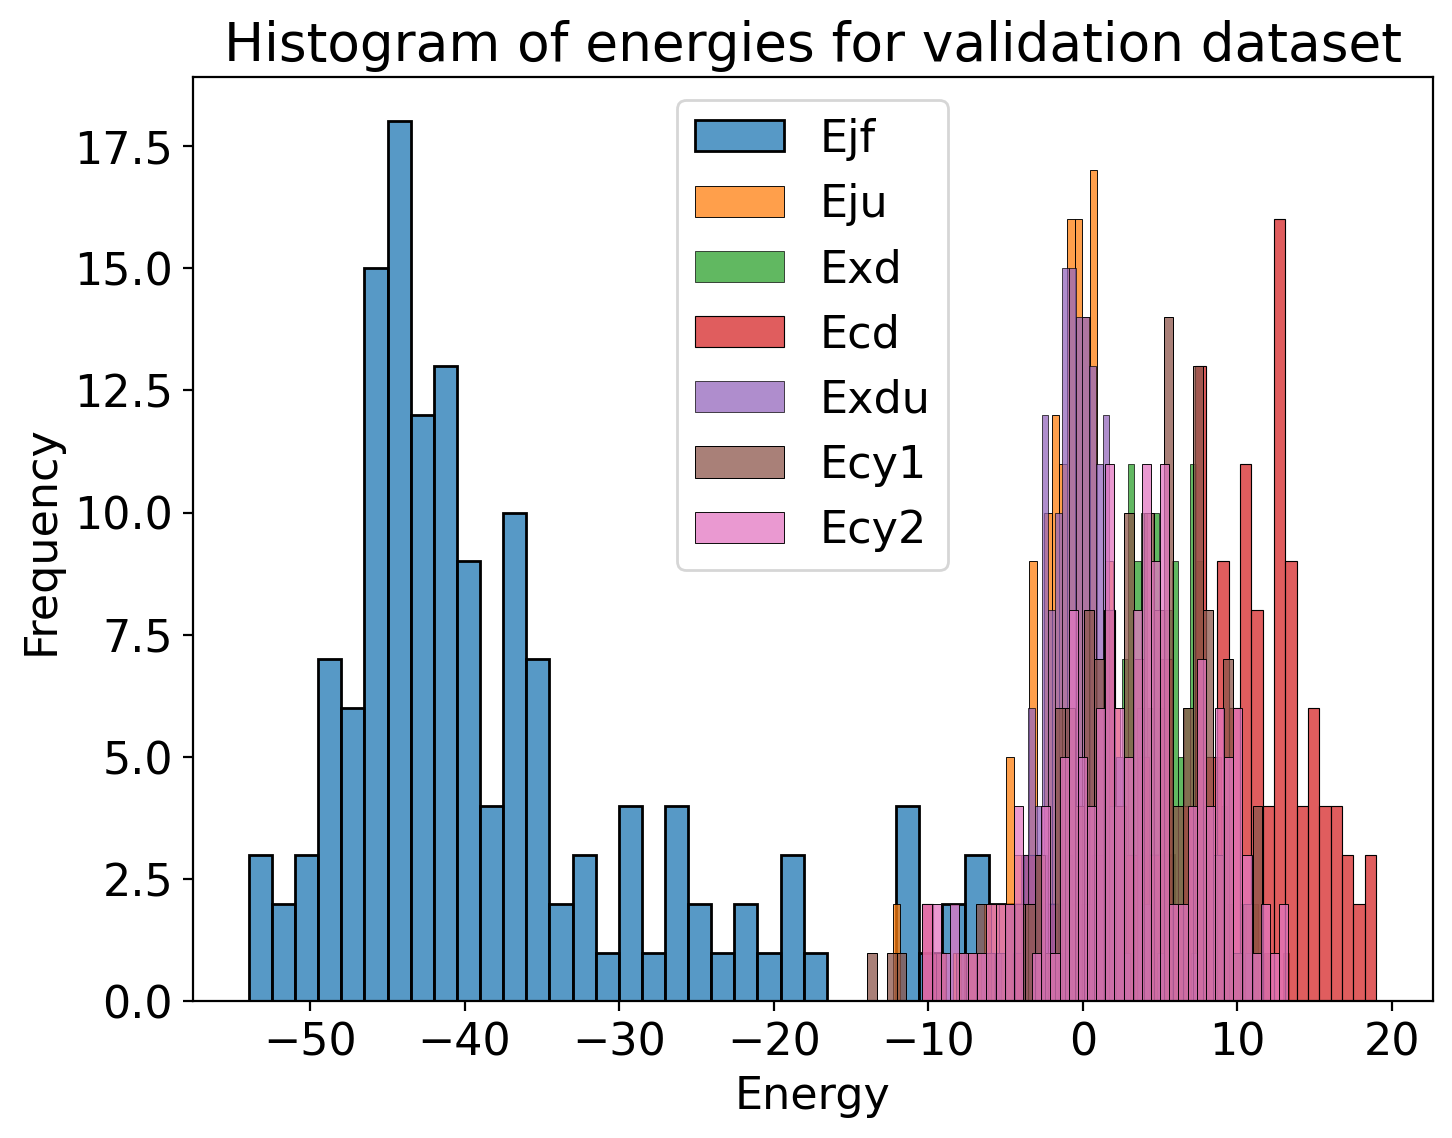

In [62]:
bins = 40
plt.figure(figsize=fig_size)
sns.histplot(val_df['Ejf'], bins=bins, label='Ejf')
sns.histplot(val_df['Eju'], bins=bins, label='Eju')
sns.histplot(val_df['Exd'], bins=bins, label='Exd')
sns.histplot(val_df['Ecd'], bins=bins, label='Ecd')
sns.histplot(val_df['Exdu'], bins=bins, label='Exdu')
sns.histplot(val_df['Ecy1'], bins=bins, label='Ecy1')
sns.histplot(val_df['Ecy2'], bins=bins, label='Ecy2')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.title('Histogram of energies for validation dataset')
plt.legend()
plt.show()

# Training and validation base plots

In [63]:
# notebook retina display
%config InlineBackend.figure_format = 'retina'
# import wandb data
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [64]:
api = wandb.Api()
run = api.run("/deepmeshi/Thermodynamic+decoy/runs/qwkava6l")
# Show history data:
print(run.history())

     sequence_len     lossg       Exd      Exdu        Ejf validation lossg  \
0           124.0  0.008213  0.812867 -0.118782   1.863470             None   
1           265.0  0.277354  7.420364 -1.312511 -19.244919             None   
2           146.0  0.876811  4.728035  2.767763 -21.077900             None   
3           159.0  0.323450  0.606789 -0.029182 -20.472939             None   
4           140.0  1.768454 -2.088063 -1.249100 -29.822811             None   
..            ...       ...       ...       ...        ...              ...   
495         184.0  0.444169  7.053099  3.353631 -37.181885             None   
496         287.0  0.411992  4.449900  0.212932 -35.062954             None   
497         200.0  1.279380  4.029596 -2.677702 -31.440557             None   
498         436.0  0.576987  4.704715 -2.905994 -34.806908             None   
499         414.0  0.649250  6.675852 -2.539474 -35.903538             None   

    learning rate       Ecy4      lossc    _timesta

In [65]:
# Plot loss and validation loss
df_loss = run.history(keys = ['lossd','lossc','lossg','loss','epoch'], samples=1000000)
# Drop na
df_loss = df_loss.dropna()
# Summerize by epoch
df_loss = df_loss.groupby('epoch').mean() [:-1]
df_loss

,_step,lossd,lossc,lossg,loss
epoch,,,,,
0,4.918646e+04,-27.613927,13.093084,0.893180,-13.627662
1,1.518144e+05,-31.214841,14.720113,0.922727,-15.572000
2,2.506486e+05,-31.837420,15.017012,1.288205,-15.532203
3,3.515630e+05,-32.694575,15.528350,0.856371,-16.309853
4,4.503222e+05,-33.219161,15.863633,0.770812,-16.584715
5,5.509215e+05,-33.117490,15.831146,0.731232,-16.555113
6,6.502248e+05,-33.088420,15.824588,0.724236,-16.539596
7,7.512031e+05,-33.729559,16.175332,0.712190,-16.842037
8,8.528076e+05,-33.213032,15.813271,0.765735,-16.634026


In [66]:
df_val_loss = run.history(keys = ['epoch','validation lossd','validation lossc','validation lossg','validation loss'], samples=1000000)
# Drop na
df_val_loss = df_val_loss.dropna(subset=['validation loss'])
# Summerize by epoch
# df_val_loss = df_val_loss.groupby('epoch').mean()
df_val_loss

,_step,epoch,validation lossd,validation lossc,validation lossg,validation loss
0,100187.0,0,-28.947149,14.664731,0.888097,-13.394321
1,200375.0,1,-31.134436,16.529118,NaN,NaN
2,300564.0,2,-33.209141,18.288698,0.908209,-14.012235
3,400753.0,3,-32.209901,17.480442,Infinity,Infinity
4,500944.0,4,-32.261395,17.185312,0.849633,-14.226451
5,601131.0,5,-33.616818,18.489523,0.809518,-14.317777
6,701319.0,6,-32.777267,17.612666,0.80187,-14.362732
7,801508.0,7,-33.913008,18.943701,0.762128,-14.207179
8,901698.0,8,-33.351082,17.935682,0.759927,-14.655473
9,1001888.0,9,-33.366579,18.016688,0.731152,-14.61874


In [67]:
# replace string values with nan
df_val_loss = df_val_loss.replace('NaN', np.nan)
df_val_loss = df_val_loss.replace('Infinity', np.nan)
df_val_loss.fillna(method='ffill', inplace=True)


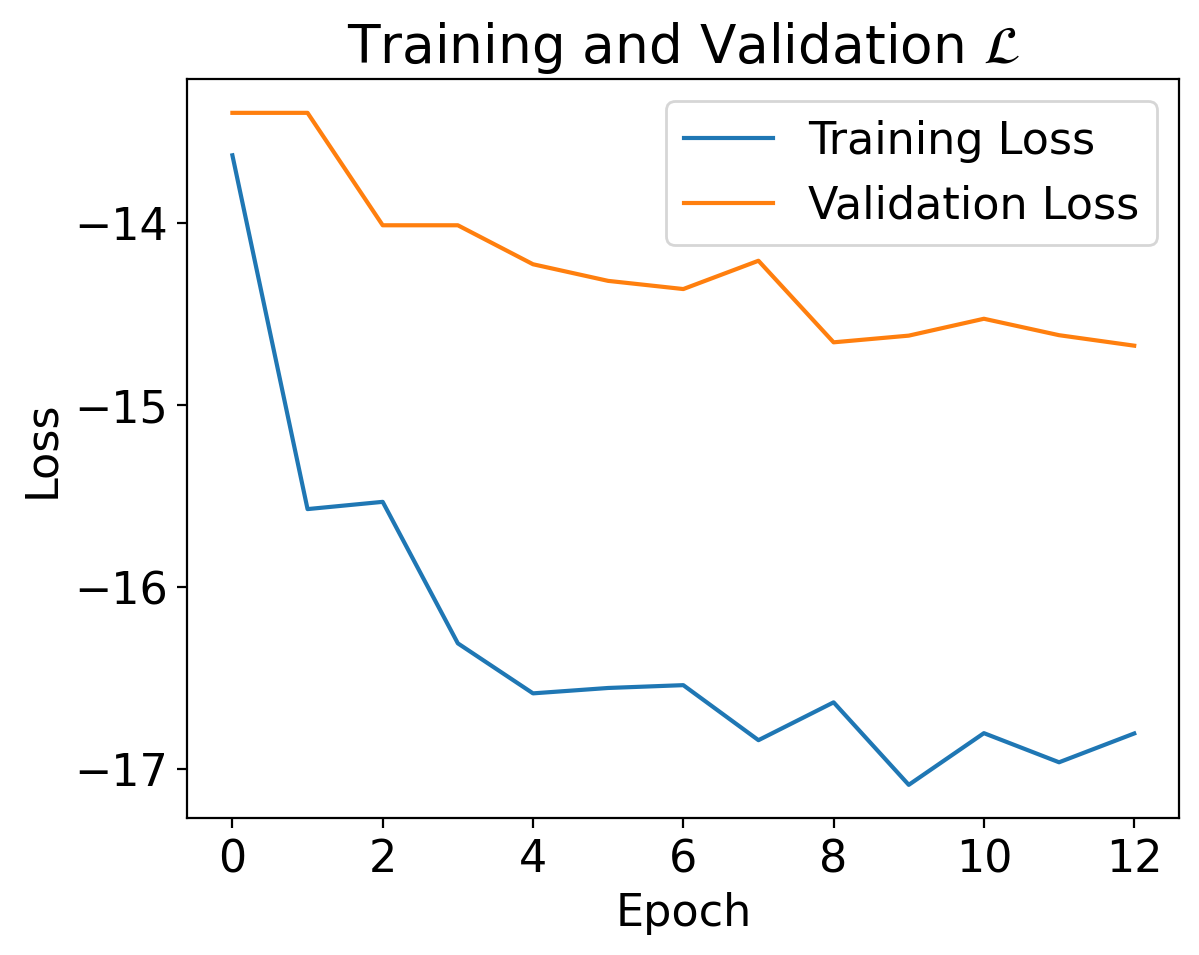

In [68]:
import matplotlib.pyplot as plt
plt.plot(df_loss.index, df_loss['loss'], label='Training Loss')
plt.plot(df_val_loss['epoch'], df_val_loss['validation loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation $\mathcal{L}$')
plt.legend()
plt.show()

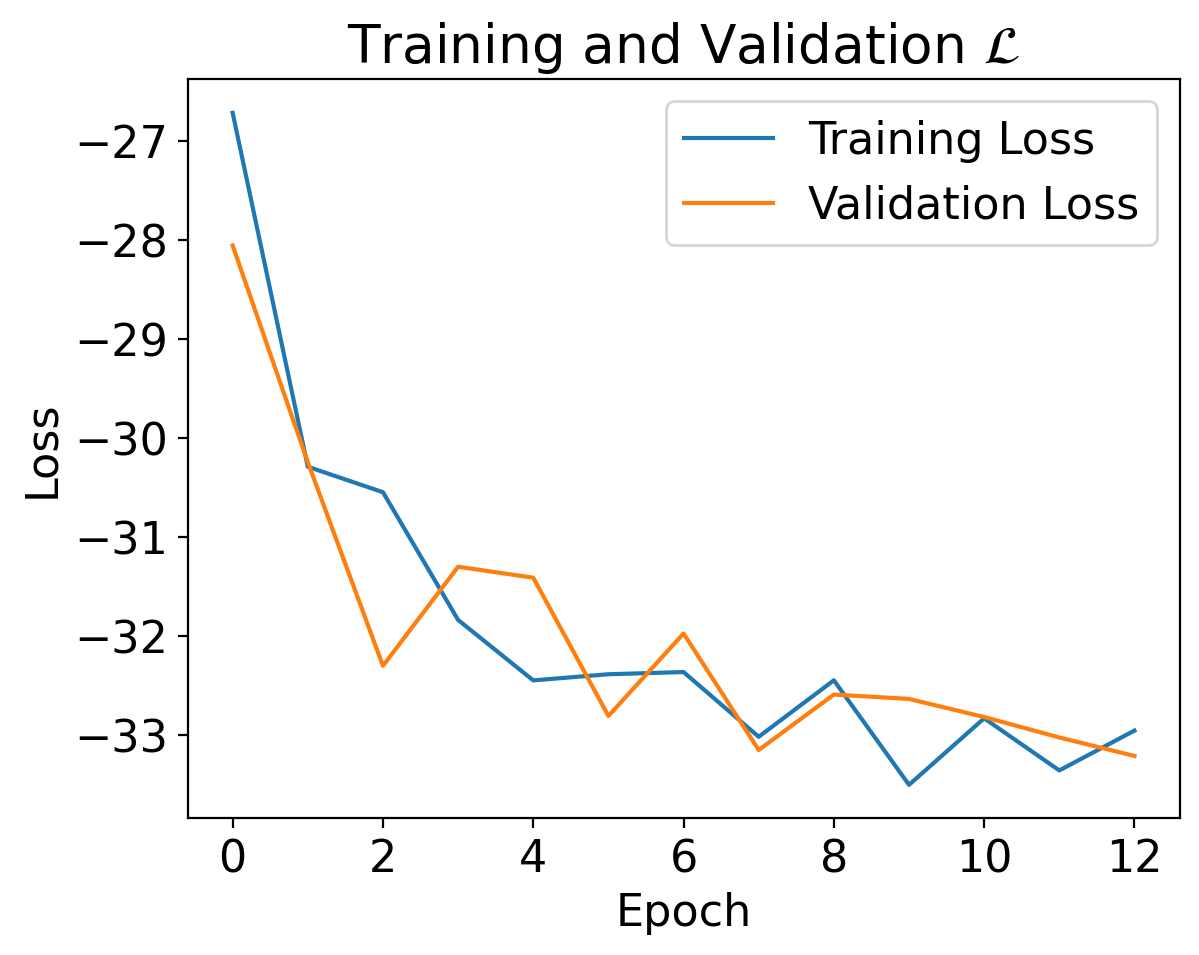

In [69]:
import matplotlib.pyplot as plt
plt.plot(df_loss.index, df_loss['lossg']+ df_loss['lossd'], label='Training Loss')
plt.plot(df_val_loss.index, df_val_loss['validation lossd']+df_val_loss['validation lossg'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation $\mathcal{L}$')
plt.legend()
plt.show()


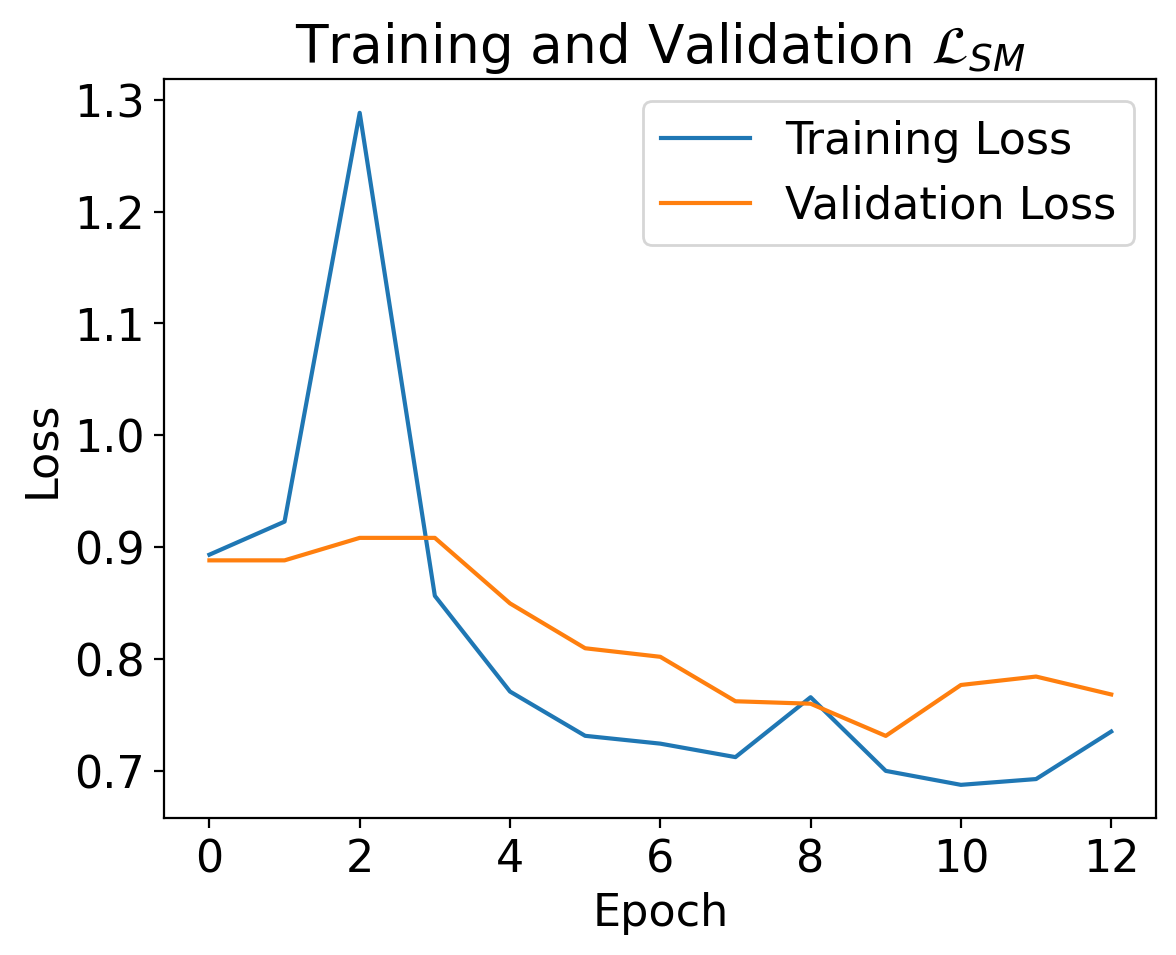

In [70]:
# Same plots for lossg, lossd and lossc
plt.plot(df_loss.index, df_loss['lossg'], label='Training Loss')
plt.plot(df_val_loss.index, df_val_loss['validation lossg'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation $\mathcal{L}_{SM}$')
plt.legend()
plt.show()

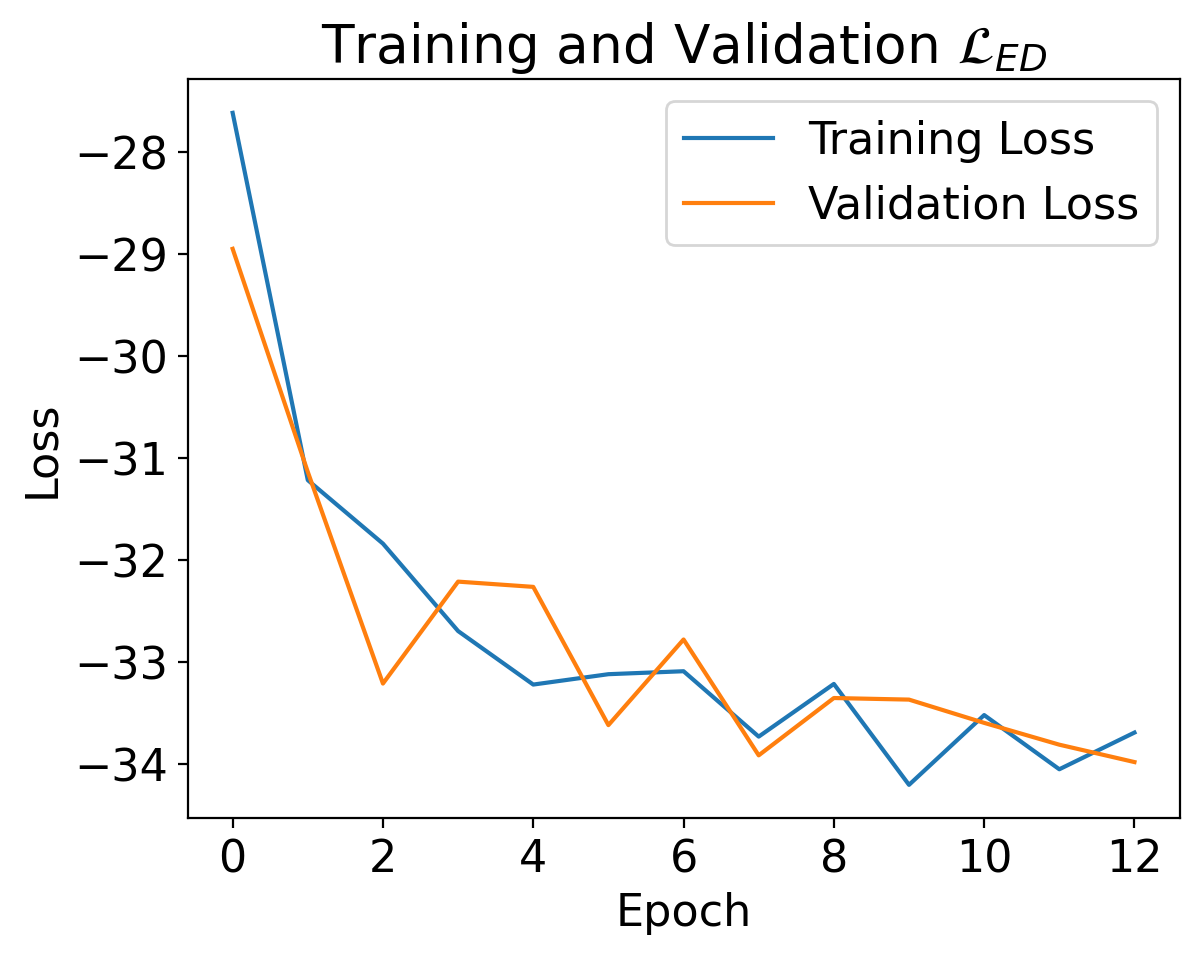

In [71]:
plt.plot(df_loss.index, df_loss['lossd'], label='Training Loss')
plt.plot(df_val_loss.index, df_val_loss['validation lossd'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation $\mathcal{L}_{ED}$')
plt.legend()
plt.show()

# Fine tunning results

In [4]:
model_res_dir = base_pred_dir+'mutation_outputs/' + 'PEM_fine_tuned-trianed_models-light_attentionkf/kf_4_epoch_49.pt/'
results = get_reults(base_pred_dir, experiment_dir, model_res_dir)
results.head()

100%|██████████| 368/368 [00:32<00:00, 11.38it/s]


,name,deltaG,aa_seq,mut_type,ddG_ML,Stabilizing_mut,folded_energies,unfolded_energies,inferred_dG,inferred_ddG,ddG,norm_folded_energies,norm_unfolded_energies,norm_avg,protein_name
0,1A0N.pdb_L7S,2.560197,VTLFVASYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGE...,wt,-0.007128562765898572,False,-1.178335,1.253205,2.431541,0.000000e+00,0.000000,-0.616777,0.638535,0.010879,1A0N
1,1A0N.pdb_L7S_wty,2.582720,VTLFVASYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGE...,wt,0.015393821934913454,False,-1.178336,1.253204,2.431540,-8.000000e-07,0.022522,-0.616778,0.638530,0.010876,1A0N
2,1A0N.pdb_L7S_wtm,2.567326,VTLFVASYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGE...,wt,0.0,False,-1.178340,1.253203,2.431543,2.000000e-06,0.007129,-0.616782,0.638527,0.010873,1A0N
3,1A0N.pdb_L7S_wte,2.552018,VTLFVASYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGE...,wt,-0.015307414252838214,False,-1.178336,1.253205,2.431541,0.000000e+00,-0.008179,-0.616777,0.638533,0.010878,1A0N
4,1A0N.pdb_L7S_wth,2.595072,VTLFVASYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGE...,wt,0.02774569070809063,False,-1.178338,1.253206,2.431544,3.500000e-06,0.034874,-0.616780,0.638538,0.010879,1A0N


In [25]:
results[results['protein_name']=='HEEH_KT_rd6_0793']['aa_seq'].iloc[0]

'TEEFVRLWREAVRHNQTLHWNGTDFIPGDEWAEEFARREEEKL'

In [5]:
# Per protein correlation
corr_per_protein = get_corr_per_protein(results)
corr_per_protein.describe()

count    368.000000
mean       0.888591
std        0.098934
min        0.134844
25%        0.858505
50%        0.921213
75%        0.947088
max        0.978796
dtype: float64

TM_results:  28314
pearson coorelation DDG 0.5567316307700277
spearman coorelation DDG 0.5548354670887357
RMSE DDG 1.0576358352410815
pearson coorelation DG 0.46397864069172445
spearman coorelation DG 0.4137797436721078
RMSE DG 1.678042679892195
Per protein correlation
Mean per protein correlation:  0.8885907020598853


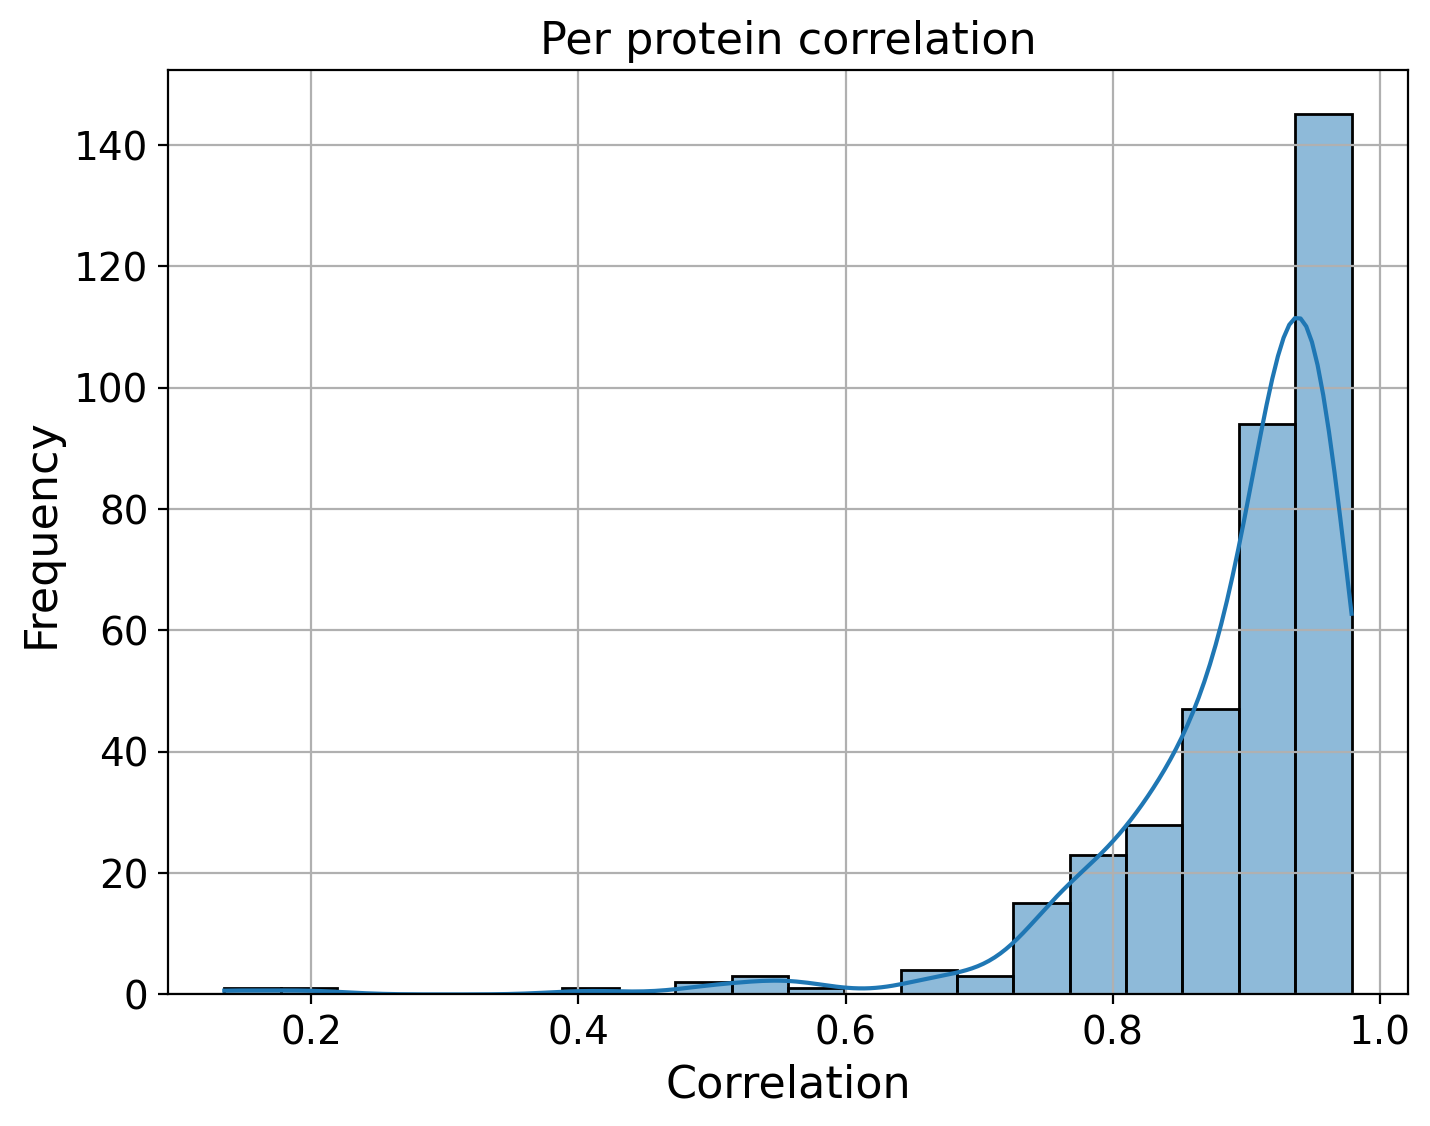

In [6]:
# Tm stat
print_TM_stat(results)
plot_TM_stat(results)

In [ ]:
# Get TM results
TM_path = "../data/ThermoMPNN/mega_test.csv"
TM_df = pd.read_csv(TM_path)
TM_df['protein_name'] = TM_df['name'].apply(lambda x: x.split(".")[0])
TM_results = results[results['name'].isin(TM_df['name_original'])]

# Calculate pearson correlation by protein
TM_corr_per_protein = TM_results.groupby('protein_name').apply(lambda x: x[['inferred_dG', 'deltaG']].corr().iloc[0,1])
TM_corr_per_protein = TM_corr_per_protein.sort_values(ascending=False)
display(TM_corr_per_protein)
print('Mean pearson corr: ', TM_corr_per_protein.mean())
print('Median pearson corr: ', TM_corr_per_protein.median())

protein_name
2K5H                   0.859610
2WXC                   0.848617
r18_3_TrROS_Hall       0.846711
2BTH                   0.840121
1W4H                   0.822928
HHH_rd1_0244           0.817581
HHH_rd1_0142           0.806922
2K28                   0.802858
2KXD                   0.802803
6EWU                   0.793569
2K1B                   0.793425
2KWH                   0.784585
6EWS                   0.784155
4C26                   0.774349
2L33                   0.766665
6EWT                   0.764812
HEEH_KT_rd6_0746       0.754546
1TUC                   0.746965
r12_757_TrROS_Hall     0.728055
1GYZ                   0.715765
1PSE                   0.708101
2LQK                   0.643839
3DKM                   0.623026
r11_1081_TrROS_Hall    0.610734
1QP2                   0.584513
1QKH                   0.525297
HEEH_KT_rd6_0793       0.389736
2KVS                   0.128028
dtype: float64

Mean pearson corr:  0.7610102424626252
Median pearson corr:  0.7705074225246551


In [19]:
# Add number of variants per protein
TM_corr_per_protein = pd.DataFrame(TM_corr_per_protein)
TM_corr_per_protein['num_variants'] = TM_results.groupby('protein_name').apply(lambda x: x.shape[0]).values
TM_corr_per_protein['STD'] = TM_results.groupby('protein_name').apply(lambda x: x['deltaG'].std()).values
TM_corr_per_protein['Seq_length'] = TM_results.groupby('protein_name').apply(lambda x: len(x['aa_seq'].iloc[0])).values
TM_corr_per_protein['aa_seq'] = TM_results.groupby('protein_name').apply(lambda x: x['aa_seq'].iloc[0]).values
TM_corr_per_protein['protein_name'] = TM_corr_per_protein.index
display(TM_corr_per_protein)

,0,num_variants,STD,Seq_length,aa_seq,protein_name
protein_name,,,,,,
2K5H,0.859610,1126,0.727997,59,WIARINAAVRAYGLNYSTFINGLKKAGIELDRKILADMAVRDPQAF...,2K5H
2WXC,0.848617,1218,0.673789,68,AIERGSKVKILRKESYWYGDVGTVASIDKSGIIYPVIVRFNKVNYN...,2WXC
r18_3_TrROS_Hall,0.846711,1272,0.807659,68,VFVDDHLLEKVLELNAKGEKRLIKTWSRRSTIVPEMVGHTIAVYNG...,r18_3_TrROS_Hall
2BTH,0.840121,1083,1.124665,63,MVQRGSKVRILRPESYWFQDVGTVASVDQSGIKYPVIVRFEKVNYS...,2BTH
1W4H,0.822928,1044,1.084799,59,GPREVTMKKGDILTLLNSTNKDWWKVEVNDRQGFVPAAYVKKLDSG...,1W4H
HHH_rd1_0244,0.817581,802,0.797587,44,NNDALSPAIRRLLAEHNLDASAIKGTGVGGRLTREDVEKHLAKA,HHH_rd1_0244
HHH_rd1_0142,0.806922,801,0.735419,44,NNDALSPAIRRLLAEHNLDASAIKGTGVGGRLTREDVEKWLAKA,HHH_rd1_0142
2K28,0.802858,934,0.847682,49,FAVESIRKKRVRKGKVEYLVKWKGWPPKYSTWEPEEHILDPRLVMAYEE,2K28
2KXD,0.802803,920,0.959180,50,AVESIEKKRIRKGRVEYLVKWRGWSPKYNTWEPEENILDPRLLIAF...,2KXD


In [21]:
print(TM_corr_per_protein[TM_corr_per_protein['protein_name'] == '2KVS']['aa_seq'].values[0])

KKIKIKIKVYNPETKEVLELEIEVSEEEAEELAKKLAEELEKKGYKIEEVEI


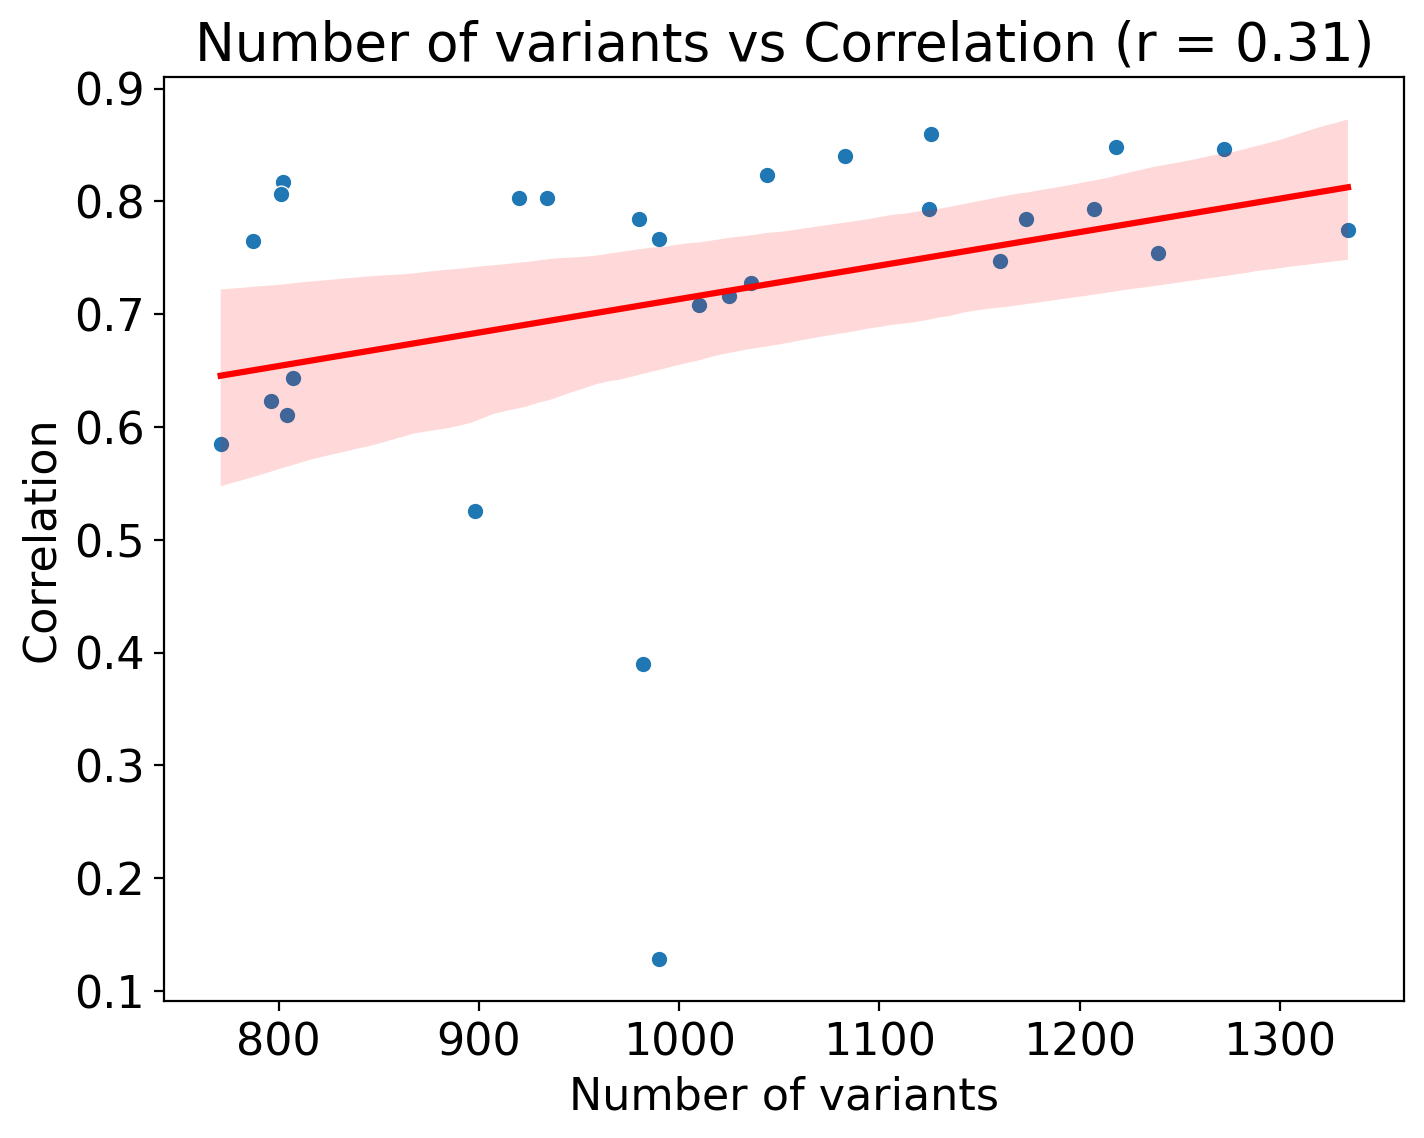

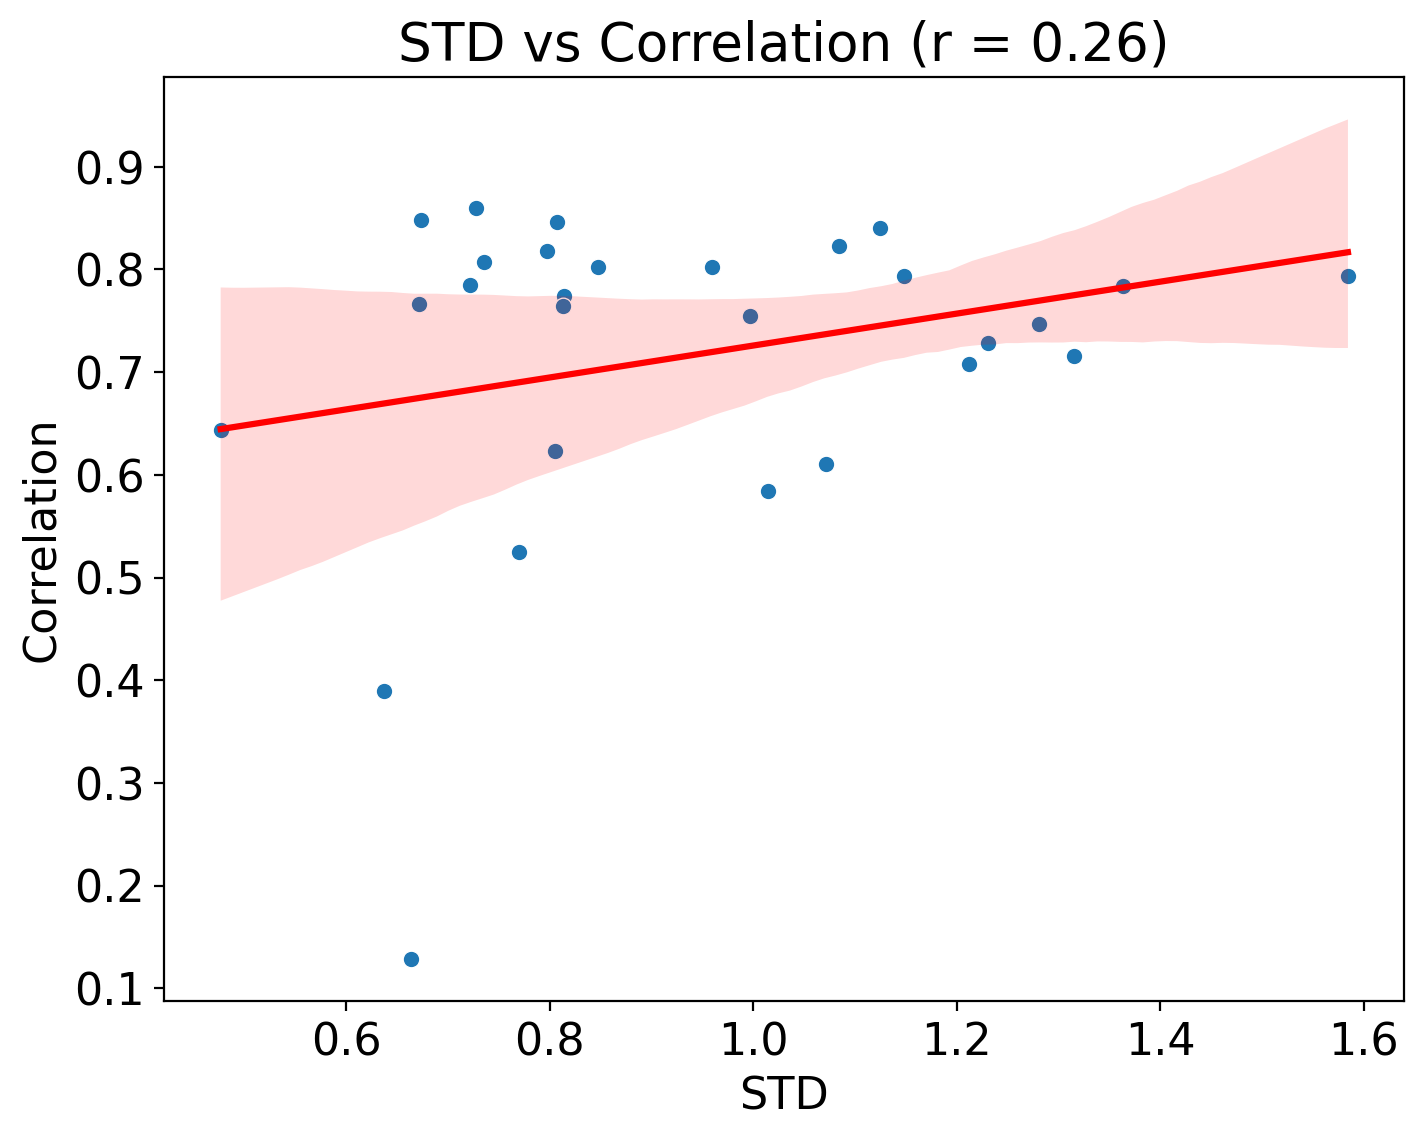

In [12]:
# Plot number of variants vs correlation
plt.figure(figsize=fig_size)
sns.scatterplot(x=TM_corr_per_protein['num_variants'], y=TM_corr_per_protein[0])
sns.regplot(x=TM_corr_per_protein['num_variants'], y=TM_corr_per_protein[0], scatter=False, color='red')
plt.xlabel('Number of variants')
plt.ylabel('Correlation')
plt.title(f'Number of variants vs Correlation (r = {TM_corr_per_protein[0].corr(TM_corr_per_protein["num_variants"]):.2f})')
plt.show()

# Plot STD vs correlation
plt.figure(figsize=fig_size)
sns.scatterplot(x=TM_corr_per_protein['STD'], y=TM_corr_per_protein[0])
sns.regplot(x=TM_corr_per_protein['STD'], y=TM_corr_per_protein[0], scatter=False, color='red')
plt.xlabel('STD')
plt.ylabel('Correlation')
plt.title(f'STD vs Correlation (r = {TM_corr_per_protein[0].corr(TM_corr_per_protein["STD"]):.2f})')
plt.show()